# Introduction to Uplift Modeling

In this notebook we present a simple example of [uplift modeling](https://en.wikipedia.org/wiki/Uplift_modelling) estimation via *meta-models* using [`causalml`](https://github.com/uber/causalml) and [`scikit-uplift`](scikit-uplift). For a more detailed introduction to uplift modeling, see:

- [Diemert, Eustache, et.al. (2020) *"A Large Scale Benchmark for Uplift Modeling"*](http://ama.imag.fr/~amini/Publis/large-scale-benchmark.pdf)

- [Gutierrez, P., & Gérardy, J. Y. (2017). *"Causal Inference and Uplift Modelling: A Review of the Literature"*](https://proceedings.mlr.press/v67/gutierrez17a/gutierrez17a.pdf)

- [Karlsson, H. (2019) *"Uplift Modeling: Identifying Optimal Treatment Group Allocation and Whom to Contact to Maximize Return on Investment"*](http://www.diva-portal.org/smash/get/diva2:1328437/FULLTEXT01.pdf)

- [Sören, R, et.al. (2019) *"Meta-learners for Estimating Heterogeneous Treatment Effects using Machine Learning"*](https://arxiv.org/abs/1706.03461)
  
- [`scikit-uplift`'s User Guide](https://www.uplift-modeling.com/en/latest/user_guide/index.html)

This material was presented at [PyCon DE & PyData Berlin2022](https://2022.pycon.de/): [Introduction to Uplift Modeling](https://2022.pycon.de/program/QY7P98/). [Here](/Presentations/pydata_2022/intro_uplift.pdf) you can find the slides.

## Prepare Notebook

In [123]:
# !pip install --upgrade pip
# !pip install causalml
# !pip install scikit-uplift
# !pip install seaborn
# !pip install ipywidgets
# !pip install lightgbm 
# !pip install scikit-learn
# !pip uninstall scikit-learn
# !pip install scikit-learn==1.3.2





Defaulting to user installation because normal site-packages is not writeable
Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Would remove:
    /Users/yulin/Library/Python/3.9/lib/python/site-packages/scikit_learn-1.6.1.dist-info/*
    /Users/yulin/Library/Python/3.9/lib/python/site-packages/sklearn/*
Proceed (Y/n)? ^C
ERROR: Operation cancelled by user
Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 11.0 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
causalml 0.15.3 requires scikit-learn>=1.5.2, but you have scikit-learn 1.3.2 which is incompa

In [1]:
from causalml.inference.meta.base import BaseLearner
from causalml.inference.meta import(
    BaseSClassifier,
    BaseTClassifier,
    BaseXClassifier,
)
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import (
    HistGradientBoostingClassifier,
    HistGradientBoostingRegressor,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklift.metrics import uplift_by_percentile, uplift_curve
from sklift.viz import (
    plot_qini_curve,
    plot_uplift_by_percentile,
    plot_uplift_curve,
)

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "png"

## Read Data

We are going to follow the example [The overview of the basic approaches to solving the Uplift Modeling problem](https://www.uplift-modeling.com/en/latest/tutorials.html#id1) presented in [`scikit-uplift`'s Tutorials Section](https://www.uplift-modeling.com/en/latest/user_guide/index.html). We extend such example by adding and EDA section on the data and using [`causalml`](https://github.com/uber/causalml) for the uplift estimation. We do use the `sklift.viz` to get diagnostics plots.

Data set: [RetailHero.ai contest data](https://ods.ai/competitions/x5-retailhero-uplift-modeling/data)

In [2]:
from pathlib import Path

data_path = Path("../retailhero-uplift/data")

# clients data
clients_df = pd.read_csv(
    data_path / "clients.csv", parse_dates=["first_issue_date", "first_redeem_date"]
)
# treatment and target data
uplift_train_df = pd.read_csv(data_path / "uplift_train.csv")


- `clients_df` data:

In [3]:
clients_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400162 entries, 0 to 400161
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   client_id          400162 non-null  object        
 1   first_issue_date   400162 non-null  datetime64[ns]
 2   first_redeem_date  364693 non-null  datetime64[ns]
 3   age                400162 non-null  int64         
 4   gender             400162 non-null  object        
dtypes: datetime64[ns](2), int64(1), object(2)
memory usage: 15.3+ MB


- `uplift_train_df` data:
- The column `treatment_flg` indicates if there was a communication. The column `target` shows if there was a purchase afterward;

In [4]:
uplift_train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200039 entries, 0 to 200038
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   client_id      200039 non-null  object
 1   treatment_flg  200039 non-null  int64 
 2   target         200039 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.6+ MB


- `purchases_df` data:

In [5]:
purchases_df = pd.read_csv(data_path / "purchases.csv")

purchases_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45786568 entries, 0 to 45786567
Data columns (total 13 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   client_id                object 
 1   transaction_id           object 
 2   transaction_datetime     object 
 3   regular_points_received  float64
 4   express_points_received  float64
 5   regular_points_spent     float64
 6   express_points_spent     float64
 7   purchase_sum             float64
 8   store_id                 object 
 9   product_id               object 
 10  product_quantity         float64
 11  trn_sum_from_iss         float64
 12  trn_sum_from_red         float64
dtypes: float64(8), object(5)
memory usage: 4.4+ GB


In [6]:
uplift_train_df

,client_id,treatment_flg,target
0,000012768d,0,1
1,000036f903,1,1
2,00010925a5,1,1
3,0001f552b0,1,1
4,00020e7b18,1,1
...,...,...,...
200034,fffe0abb97,0,0
200035,fffe0ed719,0,1
200036,fffea1204c,0,1
200037,fffeca6d22,1,0


## EDA

Let us start by exploring the data. First, let us take a look into the target and treatment variables:

[Text(0.5, 1.0, 'Targer by treatment distribution')]

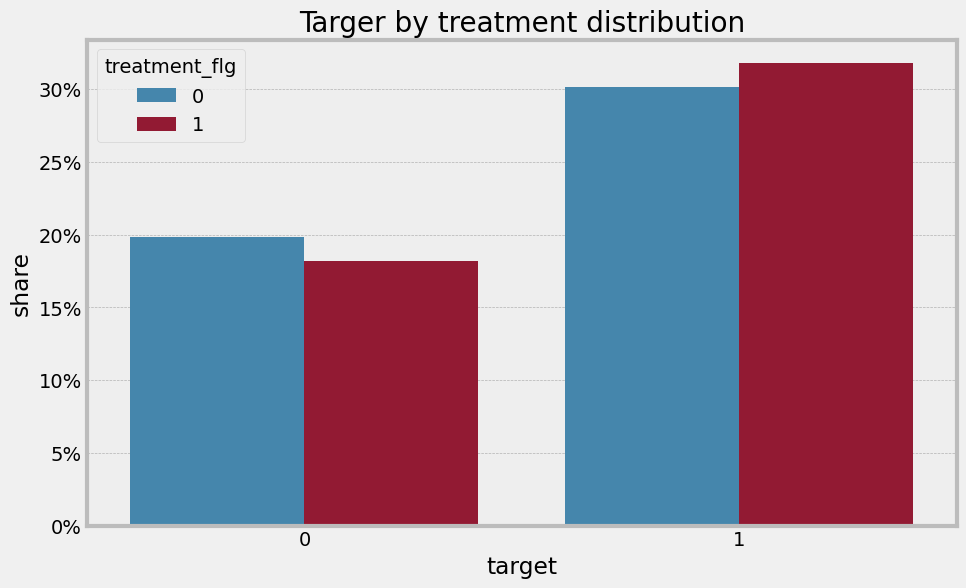

In [7]:
fig, ax = plt.subplots()

uplift_train_df.groupby(["treatment_flg", "target"], as_index=False).size().assign(
    share=lambda x: x["size"] / x["size"].sum()
).pipe((sns.barplot, "data"), x="target", y="share", hue="treatment_flg", ax=ax)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: f"{y :.0%}"))
ax.set(title="Targer by treatment distribution")


We have approximately 50/50 split of the `treatment_flg` but the `target` is not balanced (approx. 40/60).

 Now we examine the clients data. First we count the unique number of `client_id`.

In [8]:
assert clients_df.shape[0] == clients_df["client_id"].nunique()
assert uplift_train_df.shape[0] == uplift_train_df["client_id"].nunique()

print(
    f"""
clients_id
----------
clients_df: {clients_df["client_id"].nunique()}
uplift_train_df: {uplift_train_df["client_id"].nunique()}
"""
)



clients_id
----------
clients_df: 400162
uplift_train_df: 200039



We have more `client_id` in the `clients_df`. Next we merge the data by `client_id`.

In [9]:
raw_data_df = pd.merge(
    left=clients_df, right=uplift_train_df, on="client_id", how="outer"
)

assert raw_data_df.shape[0] == clients_df.shape[0]
assert raw_data_df.shape[0] == raw_data_df["client_id"].nunique()


In [10]:
raw_data_df

,client_id,first_issue_date,first_redeem_date,age,gender,treatment_flg,target
0,000012768d,2017-08-05 15:40:48,2018-01-04 19:30:07,45,U,0.0,1.0
1,000036f903,2017-04-10 13:54:23,2017-04-23 12:37:56,72,F,1.0,1.0
2,000048b7a6,2018-12-15 13:33:11,NaT,68,F,NaN,NaN
3,000073194a,2017-05-23 12:56:14,2017-11-24 11:18:01,60,F,NaN,NaN
4,00007c7133,2017-05-22 16:17:08,2018-12-31 17:17:33,67,U,NaN,NaN
...,...,...,...,...,...,...,...
400157,fffece623e,2018-05-13 15:09:30,2018-12-27 19:06:39,67,U,NaN,NaN
400158,ffff3dfff8,2018-11-01 16:06:52,2018-12-07 17:33:47,56,F,NaN,NaN
400159,ffffaab9da,2017-08-25 18:43:24,2017-12-08 17:53:19,23,F,NaN,NaN
400160,ffffeb5619,2017-12-05 13:26:28,NaT,62,U,NaN,NaN


We continue by taking a look into the `gender` feature.

**Warning:** Including `gender`-like variables in ML models can induce undesirable biases. We do keep this feature just because we want to compare the techniques with the original example. 

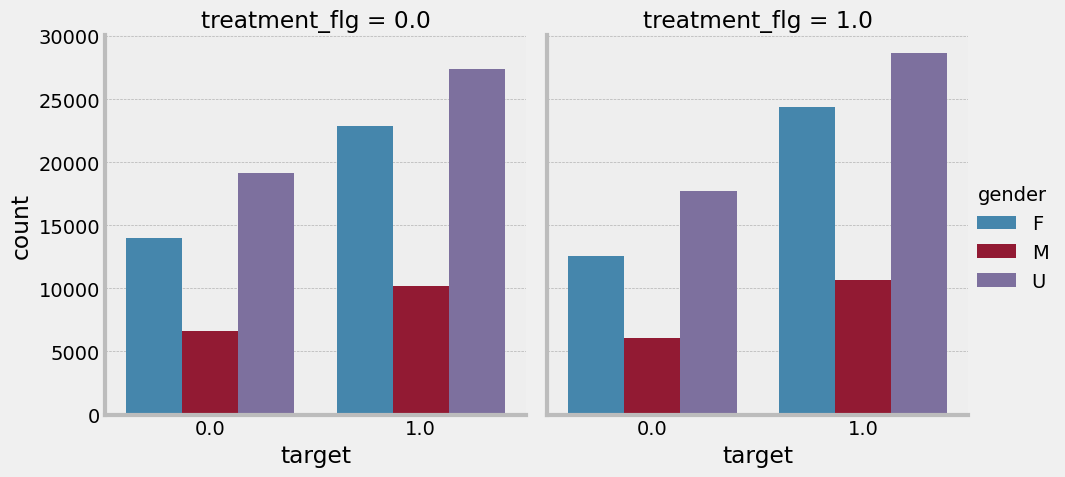

In [11]:
g = (
    raw_data_df.query("target.notnull()")
    .groupby(["treatment_flg", "target", "gender"], as_index=False)
    .agg(count=("client_id", "count"))
    .pipe(
        (sns.catplot, "data"),
        x="target",
        y="count",
        hue="gender",
        col="treatment_flg",
        kind="bar",
    )
)


Now we plot the `age distribution`. Note however, we need to remove some outliers:

In [12]:
# reasonable age range
good_age_mask = "10 < age < 100"

print(
    f"""
Rows with age outliers: 
{1 - clients_df.query(good_age_mask).shape[0] / clients_df.shape[0]: 0.2%}
"""
)



Rows with age outliers: 
 0.37%



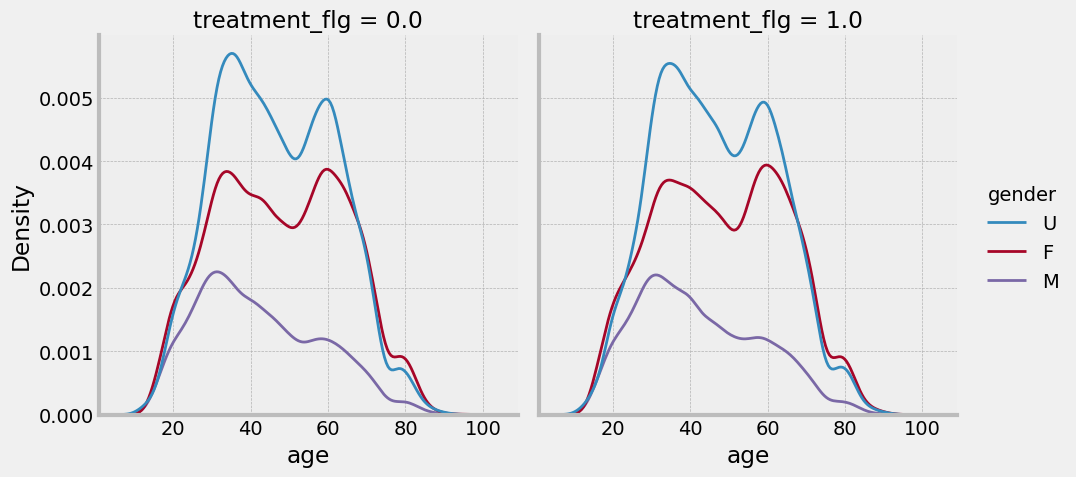

In [13]:
raw_data_df.query("(target.notnull()) and (10 < age < 100)").pipe(
    (sns.displot, "data"), x="age", hue="gender", col="treatment_flg", kind="kde"
)


We continue by studying the time variables. Note that the variable `first_redeem_date` has missing values. Let us see target and treatment distribution over these missing values.

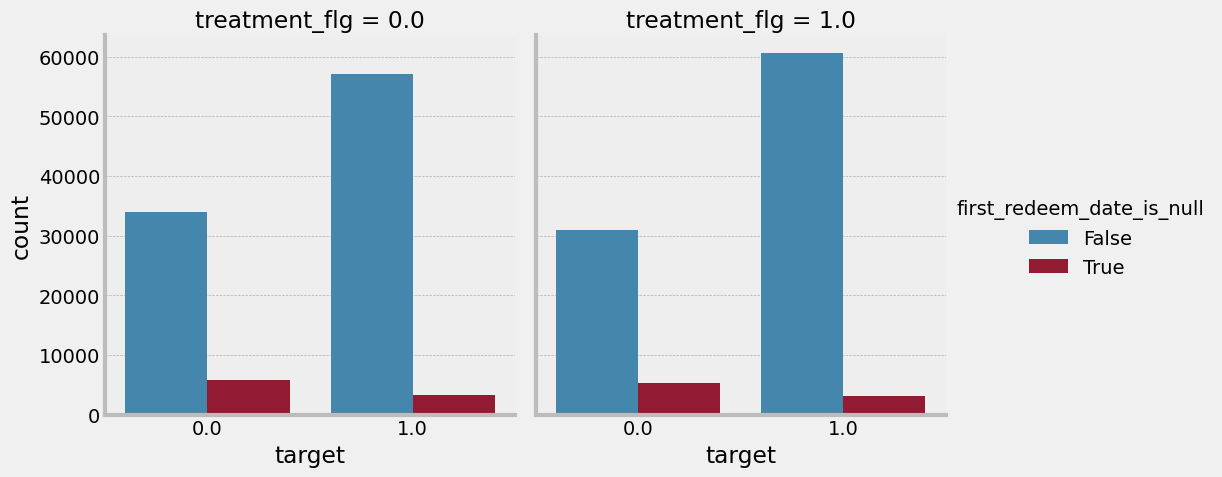

In [14]:
g = (
    raw_data_df.assign(
        first_redeem_date_is_null=lambda x: x["first_redeem_date"].isna()
    )
    .groupby(["treatment_flg", "target", "first_redeem_date_is_null"], as_index=False)
    .agg(count=("client_id", "count"))
    .pipe(
        (sns.catplot, "data"),
        x="target",
        y="count",
        hue="first_redeem_date_is_null",
        col="treatment_flg",
        kind="bar",
    )
)


We do not see any pattern at first glance. Let us see the development the client counts over `first_issue_date`.

<Axes: xlabel='first_issue_date', ylabel='count'>

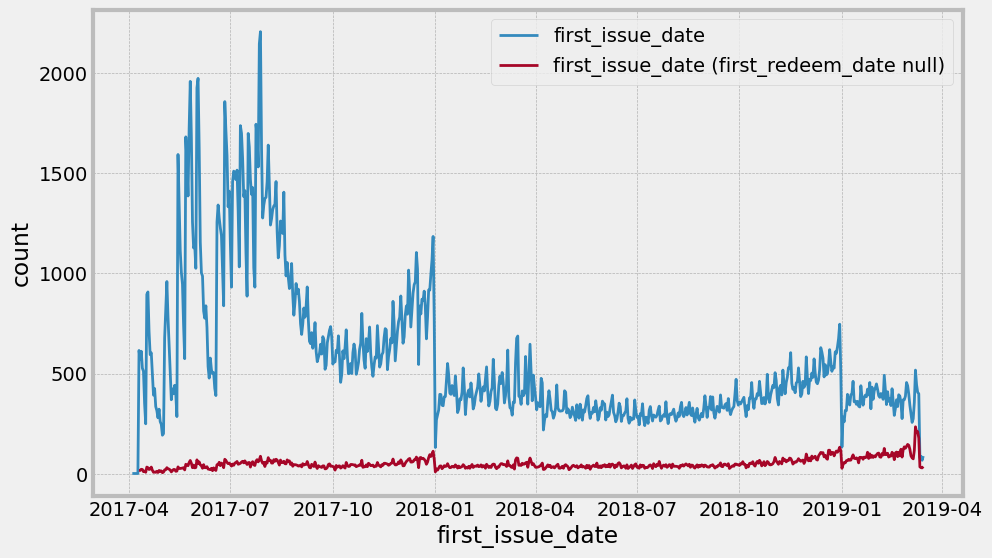

In [15]:
fig, ax = plt.subplots()

raw_data_df.assign(first_issue_date=lambda x: x["first_issue_date"].dt.date).groupby(
    ["first_issue_date"], as_index=False
).agg(count=("client_id", "count")).pipe(
    (sns.lineplot, "data"),
    x="first_issue_date",
    y="count",
    label="first_issue_date",
    ax=ax,
)

raw_data_df.query("first_redeem_date.isnull()").assign(
    first_issue_date=lambda x: x["first_issue_date"].dt.date
).groupby(["first_issue_date"], as_index=False).agg(count=("client_id", "count")).pipe(
    (sns.lineplot, "data"),
    x="first_issue_date",
    y="count",
    label="first_issue_date (first_redeem_date null)",
    ax=ax,
)


There seems to be missing values along the whole time period.

In [16]:
print(
    f"""
rows share with missing values:
{raw_data_df.query("first_redeem_date.isnull()").shape[0] / raw_data_df.shape[0]: 0.2%}
"""
)



rows share with missing values:
 8.86%



From this initial EDA there is no hint of the source of these missing values, i.e. they are at random (or maybe we are missing some information or context of the data?).

We now plot the client counts over `first_issue_date` and `first_redeem_date`:

[Text(0.5, 0, 'date'), Text(0, 0.5, 'count')]

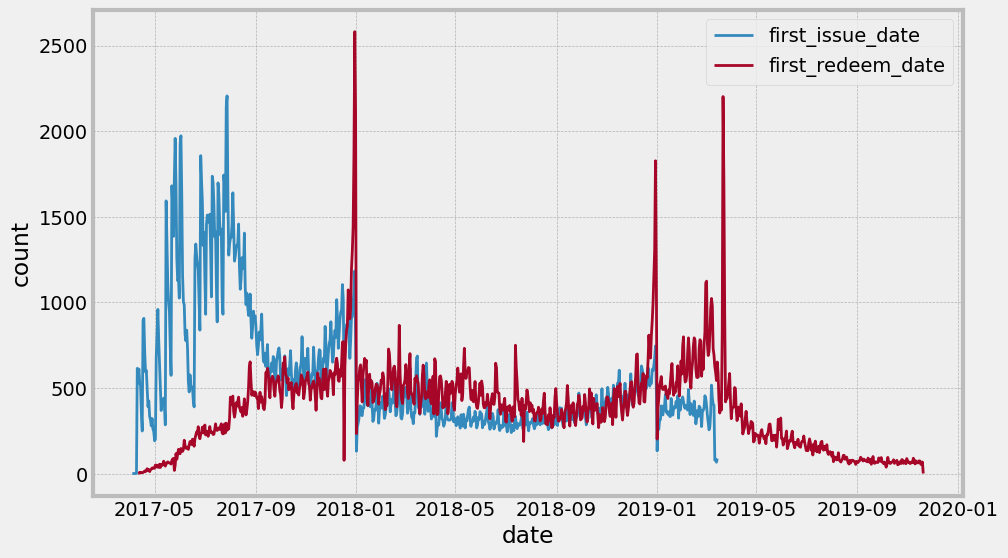

In [17]:
fig, ax = plt.subplots()

raw_data_df.assign(first_issue_date=lambda x: x["first_issue_date"].dt.date).groupby(
    ["first_issue_date"], as_index=False
).agg(count=("client_id", "count")).pipe(
    (sns.lineplot, "data"),
    x="first_issue_date",
    y="count",
    label="first_issue_date",
    ax=ax,
)

raw_data_df.assign(first_redeem_date=lambda x: x["first_redeem_date"].dt.date).groupby(
    ["first_redeem_date"], as_index=False
).agg(count=("client_id", "count")).pipe(
    (sns.lineplot, "data"),
    x="first_redeem_date",
    y="count",
    label="first_redeem_date",
    ax=ax,
)
ax.set(xlabel="date", ylabel="count")


Finally, in order to enrich our models, we calculate some simple summary metrics from the purchase data:

In [18]:
client_purchases_summary_df = (
    purchases_df.groupby(["client_id"], as_index=False)
    .agg(
        n_transactions=("transaction_id", "count"),
        n_products=("product_id", "nunique"),
        n_stores=("store_id", "nunique"),
        last_transaction_date=("transaction_datetime", "max"),
        express_points_received=("express_points_received", np.sum),
        express_points_spent=("express_points_spent", np.sum),
        regular_points_spent=("regular_points_spent", np.sum),
        mean_product_quantity=("product_quantity", np.mean),
    )
    .assign(last_transaction_date=lambda x: pd.to_datetime(x["last_transaction_date"]))
)


/var/folders/c8/wwz803497lzd6nmzk_89vpfm0000gn/T/ipykernel_76946/4039177125.py:2: FutureWarning: The provided callable <function sum at 0x1034ec5e0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  purchases_df.groupby(["client_id"], as_index=False)
/var/folders/c8/wwz803497lzd6nmzk_89vpfm0000gn/T/ipykernel_76946/4039177125.py:2: FutureWarning: The provided callable <function mean at 0x1034f0550> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  purchases_df.groupby(["client_id"], as_index=False)


**Warning:** We are using time-dependent features like ` last_transaction_date = ("transaction_datetime", "max")`, which have to be treated carefully when doing out-of-sample validation. Below we will do a train-test split by randomly selecting a fraction of the data bases on the `client_id`. Nevertheless, to have a faithful out-of-sample evaluation metrics we might want to compute these features on each split otherwise we would be leaking information. For the sake of this toy-example we will not do this.

## Prepare Data

In this section we prepare the data for uplift modeling. We will use the features from the original example (with minor modifications) plus some purchase features.

In [19]:
raw_data_df

,client_id,first_issue_date,first_redeem_date,age,gender,treatment_flg,target
0,000012768d,2017-08-05 15:40:48,2018-01-04 19:30:07,45,U,0.0,1.0
1,000036f903,2017-04-10 13:54:23,2017-04-23 12:37:56,72,F,1.0,1.0
2,000048b7a6,2018-12-15 13:33:11,NaT,68,F,NaN,NaN
3,000073194a,2017-05-23 12:56:14,2017-11-24 11:18:01,60,F,NaN,NaN
4,00007c7133,2017-05-22 16:17:08,2018-12-31 17:17:33,67,U,NaN,NaN
...,...,...,...,...,...,...,...
400157,fffece623e,2018-05-13 15:09:30,2018-12-27 19:06:39,67,U,NaN,NaN
400158,ffff3dfff8,2018-11-01 16:06:52,2018-12-07 17:33:47,56,F,NaN,NaN
400159,ffffaab9da,2017-08-25 18:43:24,2017-12-08 17:53:19,23,F,NaN,NaN
400160,ffffeb5619,2017-12-05 13:26:28,NaT,62,U,NaN,NaN


In [21]:
client_purchases_summary_df

,client_id,n_transactions,n_products,n_stores,last_transaction_date,express_points_received,express_points_spent,regular_points_spent,mean_product_quantity
0,000012768d,52,46,3,2019-03-14 15:01:47,0.0,0.0,0.0,1.038462
1,000036f903,162,96,5,2019-03-17 10:29:37,360.0,0.0,0.0,1.043210
2,000048b7a6,56,44,2,2019-03-12 10:28:19,0.0,0.0,0.0,1.625000
3,000073194a,82,68,1,2019-03-16 09:41:21,0.0,0.0,-576.0,1.548780
4,00007c7133,83,64,2,2019-03-04 16:23:30,0.0,0.0,-1680.0,1.000000
...,...,...,...,...,...,...,...,...,...
400157,fffece623e,117,83,3,2019-03-13 15:44:39,0.0,0.0,-544.0,1.076923
400158,ffff3dfff8,96,86,1,2019-03-17 16:50:01,0.0,0.0,-728.0,1.250000
400159,ffffaab9da,60,53,1,2019-03-09 18:32:50,0.0,0.0,-66.0,1.583333
400160,ffffeb5619,99,75,2,2019-03-08 12:32:49,0.0,0.0,0.0,1.101010


In [22]:
# add purchase features
raw_data_ext_df = raw_data_df.copy().merge(
    right=client_purchases_summary_df, on="client_id", how="left"
)


In [23]:
transformation_map = {
    "first_issue_time": lambda x: (
        x["first_issue_date"] - pd.Timestamp("2017-01-01")
    ).dt.days,
    "first_issue_time_weekday": lambda x: x["first_issue_date"].dt.weekday,
    "first_issue_time_month": lambda x: x["first_issue_date"].dt.month,
    "first_redeem_time": lambda x: (
        x["first_redeem_date"] - pd.Timestamp("2017-01-01")
    ).dt.days,
    "issue_redeem_delay": lambda x: (x["first_redeem_time"] - x["first_issue_time"]),
    "last_transaction_time": lambda x: (
        x["last_transaction_date"] - pd.Timestamp("2017-01-01")
    ).dt.days,
}

data_df = (
    raw_data_ext_df.copy()
    .query("target.notnull()")
    .query(good_age_mask)
    .set_index("client_id")
    .assign(**transformation_map)
    .sort_values("first_issue_time")
    .drop(
        columns=[
            "first_issue_date",
            "first_redeem_date",
            "last_transaction_date",
        ]
    )
)

data_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 199305 entries, b5e94fd9dd to 903a531bb7
Data columns (total 17 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   age                       199305 non-null  int64  
 1   gender                    199305 non-null  object 
 2   treatment_flg             199305 non-null  float64
 3   target                    199305 non-null  float64
 4   n_transactions            199305 non-null  int64  
 5   n_products                199305 non-null  int64  
 6   n_stores                  199305 non-null  int64  
 7   express_points_received   199305 non-null  float64
 8   express_points_spent      199305 non-null  float64
 9   regular_points_spent      199305 non-null  float64
 10  mean_product_quantity     199305 non-null  float64
 11  first_issue_time          199305 non-null  int64  
 12  first_issue_time_weekday  199305 non-null  int32  
 13  first_issue_time_month    199305 non

We can now show a pair-plot of the main features of the original example:

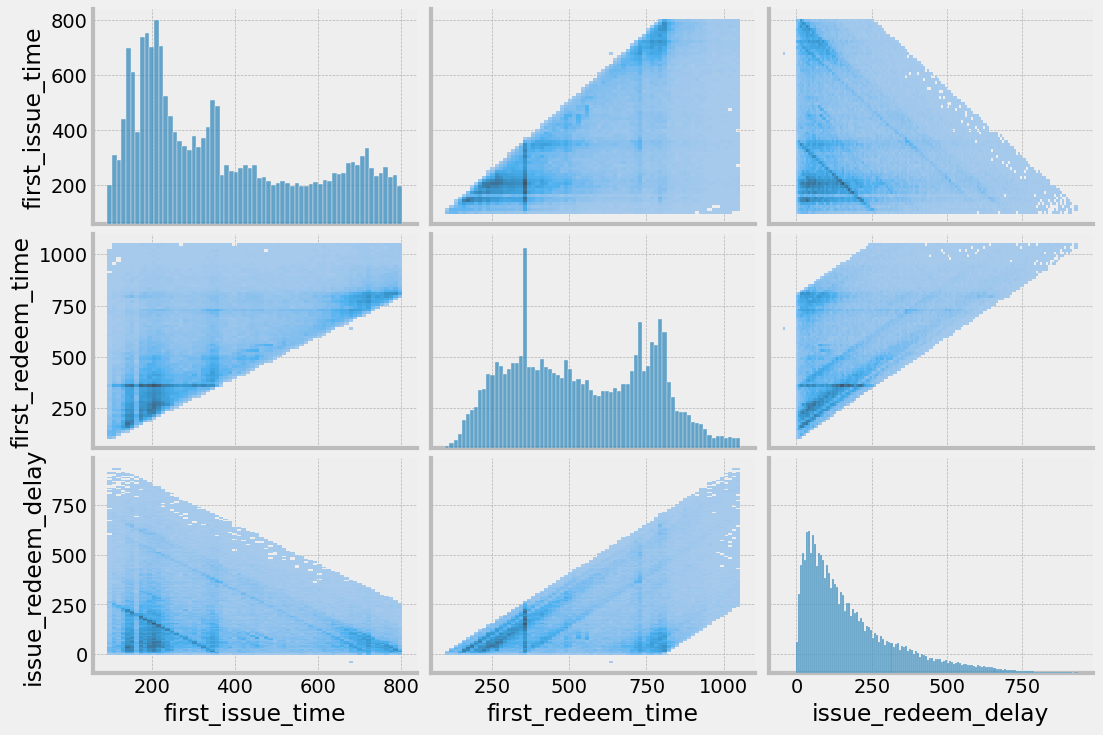

In [24]:
sns.pairplot(
    data=data_df[
        [
            "first_issue_time",
            "first_redeem_time",
            "issue_redeem_delay",
        ]
    ],
    kind="hist",
    height=2.5,
    aspect=1.5,
)


Now we do a simple train-validation split of the data.

In [25]:
target_col = "target"
treatment_col = "treatment_flg"

y = data_df[target_col]
w = data_df[treatment_col]
x = data_df.drop(columns=[treatment_col, target_col])

idx_train, idx_val = train_test_split(
    data_df.index,
    test_size=0.3,
    random_state=42,
    stratify=(y.astype(str) + "_" + w.astype(str)),
)

x_train = x.loc[idx_train]
x_val = x.loc[idx_val]

w_train = w.loc[idx_train]
w_val = w.loc[idx_val]

y_train = y.loc[idx_train]
y_val = y.loc[idx_val]


Let us encode the `gender` as an ordinal categorical variable. 

In [26]:
ordinal_encoder = OrdinalEncoder()
ordinal_encoder.fit(x_train[["gender"]])

x_train_transformed = x_train.assign(
    gender=lambda x: ordinal_encoder.transform(x[["gender"]])
)

x_val_transformed = x_val.assign(
    gender=lambda x: ordinal_encoder.transform(x[["gender"]])
)


In [27]:
ordinal_encoder.categories_

[array(['F', 'M', 'U'], dtype=object)]

## Propensity Score Model

The propensity score are defined as $p(X_{i}) = P(W_{i}=1 | X_{i})$, that is, the probability of having a treatment given the covariates. If the treatment assignment is at random these scores should be concentrated around 0.5. For a nice introduction to the subject you can see ["Propensity Score Matching: A Non-experimental Approach to Causal Inference" by Michael Johns, PyData New York 2019](https://www.youtube.com/watch?v=gaUgW7NWai8). We ser `scikit-learn`'s [`HistGradientBoostingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html). For this model we need to explicitly indicate the categorical variables:

In [28]:
categorical_features = ["gender"]

hgc_params = {
    "categorical_features": np.argwhere(
        [col in categorical_features for col in x_train_transformed.columns]
    ).flatten()
}


In [29]:
hgc_params

{'categorical_features': array([1])}

We now fit the model:

In [30]:
propensity_model = HistGradientBoostingClassifier(**hgc_params)

propensity_model.fit(X=x_train_transformed, y=w_train) # X is the training features, y is whether the customer received treatment
p_train = propensity_model.predict_proba(X=x_train_transformed)
p_val = propensity_model.predict_proba(X=x_val_transformed)

p_train = pd.Series(p_train[:, 0], index=idx_train)
p_val = pd.Series(p_val[:, 0], index=idx_val)


Lets see the results:

[Text(0.5, 1.0, 'Propensity Score Predictions Distribution'),
 Text(0.5, 0, 'propensity score'),
 Text(0, 0.5, 'density')]

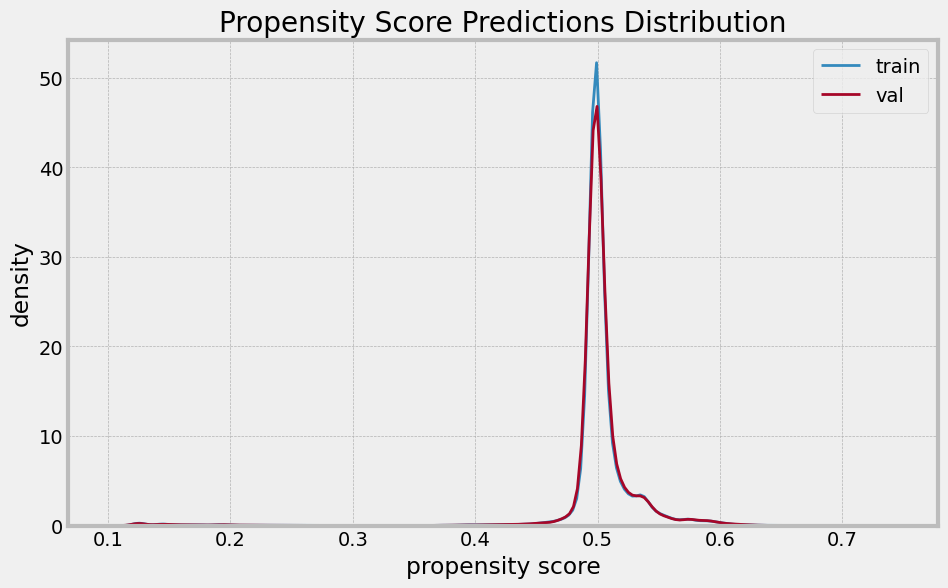

In [31]:
fig, ax = plt.subplots()
sns.kdeplot(x=p_train, label="train", ax=ax)
sns.kdeplot(x=p_val, label="val", ax=ax)
ax.legend()
ax.set(
    title="Propensity Score Predictions Distribution",
    xlabel="propensity score",
    ylabel="density",
)


In [32]:
print(
    f"""
Share of predictions with |p - 0.5| > 0.2 (train) {p_train[abs(p_train - 0.5) > 0.2].size / p_train.size : 0.2%}
Share of predictions with |p - 0.5| > 0.2 (val) {p_val[abs(p_val - 0.5) > 0.2].size / p_val.size : 0.2%}
"""
)



Share of predictions with |p - 0.5| > 0.2 (train)  1.24%
Share of predictions with |p - 0.5| > 0.2 (val)  1.26%



[Text(0.5, 1.0, 'Permutation importance propensity score model')]

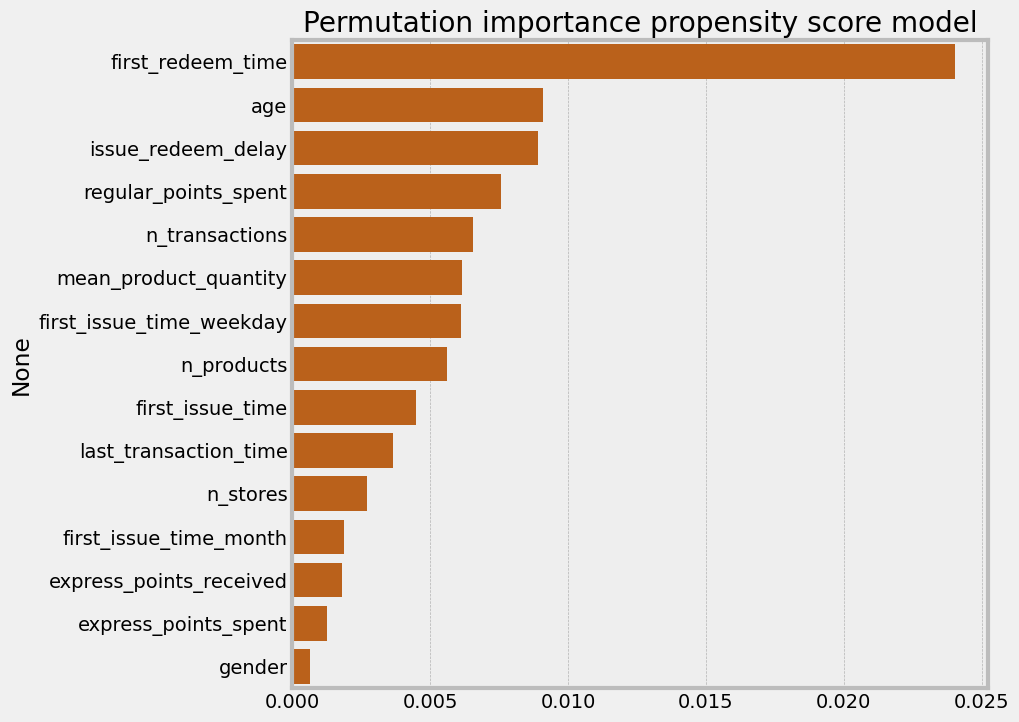

In [33]:
from sklearn.inspection import permutation_importance

pi = permutation_importance(
    estimator=propensity_model, X=x_train_transformed, y=w_train
)

fig, ax = plt.subplots(figsize=(8, 8))

idx = pi["importances_mean"].argsort()[::-1]

sns.barplot(
    x=pi["importances_mean"][idx], y=x_train_transformed.columns[idx], color="C4", ax=ax
)
ax.set(title="Permutation importance propensity score model")


## Data Container

We now define a convenient data structure for the uplift  models input data.

In [34]:
from dataclasses import dataclass


@dataclass
class DataIn:
    x: pd.DataFrame
    x_transformed: np.array
    y: pd.Series
    treatment: pd.Series
    p: pd.Series


data_train = DataIn(
    x=x_train,
    x_transformed=x_train_transformed,
    y=y_train,
    treatment=w_train,
    p=p_train,
)

data_val = DataIn(
    x=x_val, x_transformed=x_val_transformed, y=y_val, treatment=w_val, p=p_val
)


---

## Models

Now that we have a better understanding of the data we can start modeling. We use some of the *meta-learners* from [`causalml`](https://github.com/uber/causalml). For more details please see the [`causalml` documentation](https://causalml.readthedocs.io/en/latest/methodology.html#meta-learner-algorithms).

### S-Learner

In this meta-model we simply train an ML model to predict the `target` variable using the covariates $X$ plus the `target` as regressors.

-  **Step 1: Training**

$$
\underbrace{
\left(
\begin{array}{cccc}
x_{11} & \cdots & x_{1k} & w_{1} \\
\vdots & \ddots & \vdots & \vdots \\
x_{11} & \cdots & x_{nk} & w_{n} \\
\end{array}
\right)}_{X\bigoplus W}
\xrightarrow{\mu}
\left(
\begin{array}{c}
y_{1} \\
\vdots \\
y_{n}
\end{array}
\right)
$$

- **Step 2: Uplift Prediction**

$$
\widehat{\text{\bf{uplift}}} = 
\hat{\mu}\left(
\begin{array}{cccc}
x_{11} & \cdots & x_{1k} & 1 \\
\vdots & \ddots & \vdots & \vdots \\
x_{11} & \cdots & x_{mk} & 1 \\
\end{array}
\right)
-
\hat{\mu}
\left(
\begin{array}{cccc}
x_{11} & \cdots & x_{1k} & 0 \\
\vdots & \ddots & \vdots & \vdots \\
x_{11} & \cdots & x_{mk} & 0 \\
\end{array}
\right)
$$

In [35]:
s_learner = BaseSClassifier(learner=HistGradientBoostingClassifier(**hgc_params))

s_ate = s_learner.estimate_ate(
    X=data_train.x_transformed, treatment=data_train.treatment, y=data_train.y
)


One can access the trained model as:

In [36]:
s_learner.models[1]


HistGradientBoostingClassifier(categorical_features=array([1]))

### T-Learner

For this one we train two ML models instead: one for each treatment assignment.

- **Step 1: Training**

$$
\underbrace{
\left(
\begin{array}{ccc}
x_{11} & \cdots & x_{1k} \\
\vdots & \ddots & \vdots \\
x_{11} & \cdots & x_{n_{C}k} \\
\end{array}
\right)}_{X|_{\text{control}}}
\xrightarrow{\mu_{C}}
\left(
\begin{array}{c}
y_{1} \\
\vdots \\
y_{n_{C}}
\end{array}
\right)
$$

$$
\underbrace{
\left(
\begin{array}{ccc}
x_{11} & \cdots & x_{1k}  \\
\vdots & \ddots & \vdots \\
x_{11} & \cdots & x_{n_{T}k} \\
\end{array}
\right)}_{X |_{\text{treatment}}}
\xrightarrow{\mu_{T}}
\left(
\begin{array}{c}
y_{1} \\
\vdots \\
y_{n_{T}}
\end{array}
\right) 
$$

- **Step 2: Uplift Prediction**

$$
\widehat{\text{\bf{uplift}}} = 
\hat{\mu}_{T}\left(
\begin{array}{cccc}
x_{11} & \cdots & x_{1k} \\
\vdots & \ddots & \vdots \\
x_{11} & \cdots & x_{mk} \\
\end{array}
\right)
-
\hat{\mu}_{C}
\left(
\begin{array}{cccc}
x_{11} & \cdots & x_{1k} \\
\vdots & \ddots & \vdots \\
x_{11} & \cdots & x_{mk} \\
\end{array}
\right)
$$

In [37]:
t_learner = BaseTClassifier(learner=HistGradientBoostingClassifier(**hgc_params))

t_ate_lwr, t_ate, t_ate_upr = t_learner.estimate_ate(
    X=data_train.x_transformed, treatment=data_train.treatment, y=data_train.y
)


One can access the trained models as:

In [38]:
t_learner.models_c[1]  # control group
t_learner.models_t[1]  # treatment group


HistGradientBoostingClassifier(categorical_features=array([1]))

### X-Learner

The X-Learner is similar to the T-Learner but it adds and additional step where we transfer information from one model to the other, see [Sören, R, et.al. (2019) *"Meta-learners for Estimating Heterogeneous Treatment Effects using Machine Learning"*](https://arxiv.org/abs/1706.03461) for details on the motivation.

- **Step 1: Training**

$$
\underbrace{
\left(
\begin{array}{ccc}
x_{11} & \cdots & x_{1k} \\
\vdots & \ddots & \vdots \\
x_{11} & \cdots & x_{n_{C}k} \\
\end{array}
\right)}_{X|_{\text{control}}}
\xrightarrow{\mu_{C}}
\left(
\begin{array}{c}
y_{1} \\
\vdots \\
y_{n_{C}}
\end{array}
\right)
$$

$$
\underbrace{
\left(
\begin{array}{ccc}
x_{11} & \cdots & x_{1k}  \\
\vdots & \ddots & \vdots \\
x_{11} & \cdots & x_{n_{T}k} \\
\end{array}
\right)}_{X |_{\text{treatment}}}
\xrightarrow{\mu_{T}}
\left(
\begin{array}{c}
y_{1} \\
\vdots \\
y_{n_{T}}
\end{array}
\right) 
$$

- **Step 2: Compute imputed treatment effects**

$$
\tilde{D}^{T} \coloneqq
\left(
\begin{array}{c}
y_{1} \\
\vdots \\
y_{n_{T}}
\end{array}
\right)
- 
\hat{\mu}_{C}
\left(
\begin{array}{cccc}
x_{11} & \cdots & x_{1k} \\
\vdots & \ddots & \vdots \\
x_{11} & \cdots & x_{n_{T}k} \\
\end{array}
\right)
$$

$$
\tilde{D}^{C} \coloneqq
\hat{\mu}_{T}
\left(
\begin{array}{cccc}
x_{11} & \cdots & x_{1k} \\
\vdots & \ddots & \vdots \\
x_{11} & \cdots & x_{n_{C}k} \\
\end{array}
\right)
-
\left(
\begin{array}{c}
y_{1} \\
\vdots \\
y_{n_{C}}
\end{array}
\right)
$$

- **Step 3: Uplift train with different targets**

$$
\underbrace{
\left(
\begin{array}{ccc}
x_{11} & \cdots & x_{1k} \\
\vdots & \ddots & \vdots \\
x_{11} & \cdots & x_{n_{C}k} \\
\end{array}
\right)}_{X|_{\text{control}}}
\xrightarrow{\tau_{C}}
\left(
\begin{array}{c}
\tilde{D}^{C}_{1} \\
\vdots \\
\tilde{D}^{C}_{n_{C}}
\end{array}
\right)
$$

$$
\underbrace{
\left(
\begin{array}{ccc}
x_{11} & \cdots & x_{1k} \\
\vdots & \ddots & \vdots \\
x_{11} & \cdots & x_{n_{T}k} \\
\end{array}
\right)}_{X|_{\text{treatment}}}
\xrightarrow{\tau_{T}}
\left(
\begin{array}{c}
\tilde{D}^{T}_{1} \\
\vdots \\
\tilde{D}^{T}_{n_{T}}
\end{array}
\right)
$$

- **Step 4: Uplift Prediction**

$$
\widehat{\text{\bf{uplift}}} = g(x)\hat{\tau}_{C}(x) + (1 - g(x))\hat{\tau}_{T}(x)
$$

where $g(x) \in [0, 1]$ is a weight function.

**Remark:** From [Sören, R, et.al. (2019) *"Meta-learners for Estimating Heterogeneous Treatment Effects using Machine Learning"*](https://arxiv.org/abs/1706.03461):
> *$\hat{\tau}_{C}$ and $\hat{\tau}_{T}$ are both estimators for $\tau$ (the uplift) while $g$ is chosen to combine these estimators to one improved estimator $\hat{\tau}$. Based on our experience, we observe that it is good to use an estimate of the propensity score for $g$, but it also makes sense to choose $g = 1$ or $0$, if the number of treated units is very large or small compared to the number of control units.*

In [39]:
x_learner = BaseXClassifier(
    outcome_learner=HistGradientBoostingClassifier(**hgc_params),
    effect_learner=HistGradientBoostingRegressor(**hgc_params),
)

x_ate_lwr, x_ate, x_ate_upr = x_learner.estimate_ate(
    X=data_train.x_transformed,
    treatment=data_train.treatment,
    y=data_train.y,
    p=data_train.p,
)


One can access the trained models as:

In [40]:
# step 1
x_learner.models_mu_c[1]  # control group
x_learner.models_mu_t[1]  # treatment group
# step 3
x_learner.models_tau_c[1]  # control group
x_learner.models_tau_t[1]  # treatment group


HistGradientBoostingRegressor(categorical_features=array([1]))

[Text(0.5, 1.0, 'ATE Estimation (Train)')]

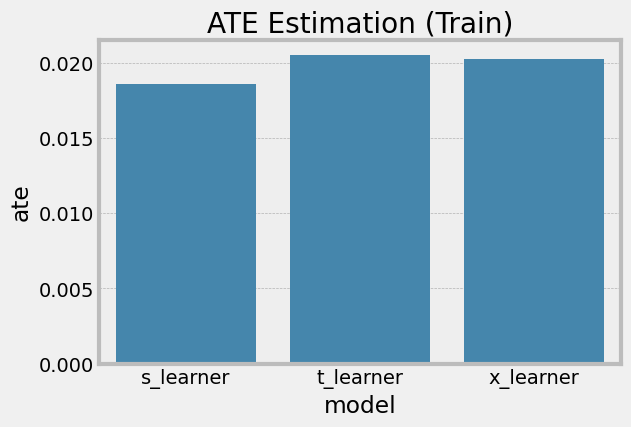

In [41]:
fig, ax = plt.subplots(figsize=(6, 4))

pd.DataFrame(
    data={
        "model": ["s_learner", "t_learner", "x_learner"],
        "ate": np.array([s_ate, t_ate, x_ate]).flatten(),
    },
).pipe((sns.barplot, "data"), x="model", y="ate", ax=ax)
ax.set(title="ATE Estimation (Train)")


---

## Predictions & Diagnostics

Next, now that we have fitted meta-learner models, we generate predictions in the training and validations sets.

In [42]:
@dataclass
class DataOut:
    meta_learner_name: str
    meta_learner: BaseLearner
    y_pred: np.array


# in-sample predictions
data_out_train_s = DataOut(
    meta_learner_name="S-Learner",
    meta_learner=s_learner,
    y_pred=s_learner.predict(
        X=data_train.x_transformed, treatment=data_train.treatment
    ),
)
data_out_train_t = DataOut(
    meta_learner_name="T-Learner",
    meta_learner=t_learner,
    y_pred=t_learner.predict(
        X=data_train.x_transformed, treatment=data_train.treatment
    ),
)
data_out_train_x = DataOut(
    meta_learner_name="X-Learner",
    meta_learner=x_learner,
    y_pred=x_learner.predict(
        X=data_train.x_transformed, treatment=data_train.treatment, p=data_train.p
    ),
)
# out-of-sample predictions
data_out_val_s = DataOut(
    meta_learner_name="S-Learner",
    meta_learner=s_learner,
    y_pred=s_learner.predict(X=data_val.x_transformed, treatment=data_val.treatment),
)
data_out_val_t = DataOut(
    meta_learner_name="T-Learner",
    meta_learner=t_learner,
    y_pred=t_learner.predict(X=data_val.x_transformed, treatment=data_val.treatment),
)
data_out_val_x = DataOut(
    meta_learner_name="X-Learner",
    meta_learner=x_learner,
    y_pred=x_learner.predict(
        X=data_val.x_transformed, treatment=data_val.treatment, p=data_val.p
    ),
)


/Users/yulin/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but HistGradientBoostingClassifier was fitted without feature names
  warnings.warn(
/Users/yulin/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but HistGradientBoostingClassifier was fitted without feature names
  warnings.warn(
/Users/yulin/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but HistGradientBoostingClassifier was fitted without feature names
  warnings.warn(
/Users/yulin/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but HistGradientBoostingClassifier was fitted without feature names
  warnings.warn(


A natural question is: how well do we predict the uplift? Note that ([Gutierrez, P., & Gérardy, J. Y. (2017). *"Causal Inference and Uplift Modelling: A Review of the Literature"*](https://proceedings.mlr.press/v67/gutierrez17a/gutierrez17a.pdf)):

> *In machine learning, the standard is to use cross-validation: separate the data into a training and a testing datasets; learn on the training data, predict the target on the test data and compare to the ground truth. In uplift modeling, cross validation is still a valid idea but there is no more ground truth because we can never observe the effect of being treated and not treated on a person at the same time.*

To answer it we deep dive into some common model diagnostic tools.

### Perfect uplift prediction

How would a perfect uplift model predict? Following [Diemert, Eustache, et.al. (2020) "A Large Scale Benchmark for Uplift Modeling"](http://ama.imag.fr/~amini/Publis/large-scale-benchmark.pdf),
> A perfect model assigns higher scores to all treated individuals with positive outcomes than any individuals with negative outcomes.




In [43]:
def perfect_uplift_model(data: DataIn):
    # control Responders
    cr_num = np.sum((data.y == 1) & (data.treatment == 0))
    # treated Non-Responders
    tn_num = np.sum((data.y == 0) & (data.treatment == 1))

    # compute perfect uplift curve
    summand = data.y if cr_num > tn_num else data.treatment
    return 2 * (data.y == data.treatment) + summand


perfect_uplift_train = perfect_uplift_model(data=data_train)
perfect_uplift_val = perfect_uplift_model(data=data_val)


In [56]:
perfect_uplift_train

client_id
19bda15ee9    3.0
fc34cdfa96    0.0
6b4778b5af    1.0
6dee8c2f69    0.0
a7f6dbdf5b    3.0
             ... 
4cabe73d9c    1.0
51b60c4159    2.0
9896c4f2d7    1.0
549ca4f5c7    3.0
3f77ac6044    2.0
Length: 139513, dtype: float64

We can compare the sorted predictions of the models against the perfect one.

Text(0.5, 0.98, 'np.sort(a=uplift_prediction)[::-1] (train)')

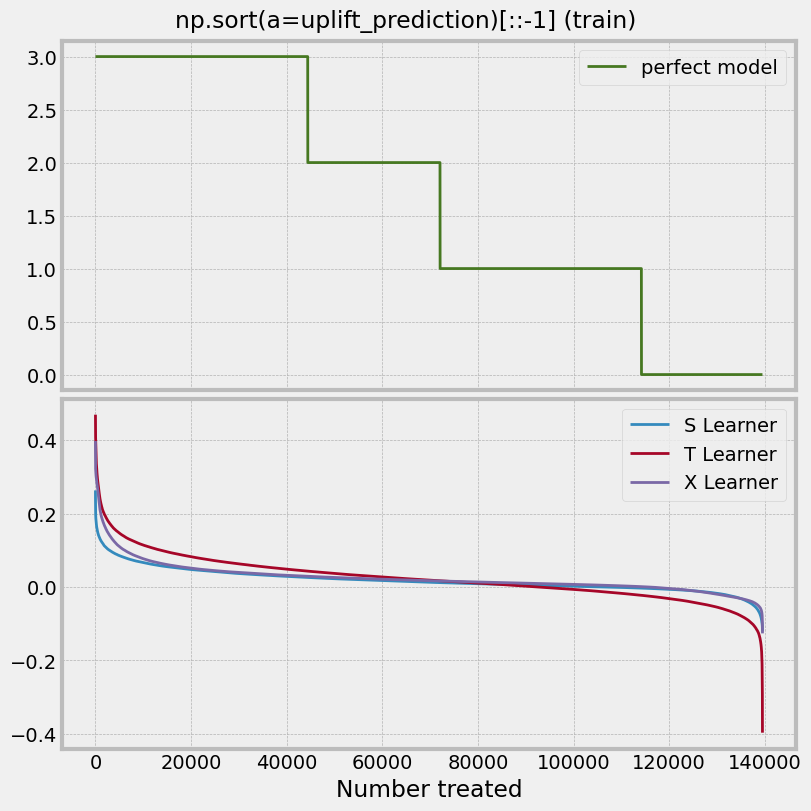

In [44]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(8, 8), sharex=True, layout="constrained"
)
sns.lineplot(
    x=range(data_train.y.size),
    y=np.sort(a=perfect_uplift_train)[::-1],
    color="C3",
    label="perfect model",
    ax=ax[0],
)
sns.lineplot(
    x=range(data_train.y.size),
    y=np.sort(a=data_out_train_s.y_pred.flatten())[::-1],
    color="C0",
    label="S Learner",
    ax=ax[1],
)
sns.lineplot(
    x=range(data_train.y.size),
    y=np.sort(a=data_out_train_t.y_pred.flatten())[::-1],
    color="C1",
    label="T Learner",
    ax=ax[1],
)
sns.lineplot(
    x=range(data_train.y.size),
    y=np.sort(a=data_out_train_x.y_pred.flatten())[::-1],
    color="C2",
    label="X Learner",
    ax=ax[1],
)
ax[1].set(xlabel="Number treated")
fig.suptitle("np.sort(a=uplift_prediction)[::-1] (train)")


### Uplift by percentile

1. Sort uplift predictions by decreasing order.
2. Predict uplift for both treated and control observations
3. Compute the average prediction per percentile in both groups.
4. The difference between those averages is taken for each percentile.

This difference gives an idea of the uplift gain per percentile. One can compute this using the `uplift_by_percentile` function (from [`sklift.metrics`](https://github.com/maks-sh/scikit-uplift/blob/master/sklift/metrics/metrics.py)). Let us see how the data looks for the S learner.

In [44]:

from sklift.metrics import response_rate_by_percentile


# The source code of uplift_by_percentile seems to have a bug, which 

def uplift_by_percentile(y_true, uplift, treatment, strategy='overall',
                         bins=10, std=False, total=False, string_percentiles=True):
    """Compute metrics: uplift, group size, group response rate, standard deviation at each percentile.

    Metrics in columns and percentiles in rows of pandas DataFrame:

        - ``n_treatment``, ``n_control`` - group sizes.
        - ``response_rate_treatment``, ``response_rate_control`` - group response rates.
        - ``uplift`` - treatment response rate substract control response rate.
        - ``std_treatment``, ``std_control`` - (optional) response rates standard deviation.
        - ``std_uplift`` - (optional) uplift standard deviation.

    Args:
        y_true (1d array-like): Correct (true) binary target values.
        uplift (1d array-like): Predicted uplift, as returned by a model.
        treatment (1d array-like): Treatment labels.
        strategy (string, ['overall', 'by_group']): Determines the calculating strategy. Default is 'overall'.

            * ``'overall'``:
                The first step is taking the first k observations of all test data ordered by uplift prediction
                (overall both groups - control and treatment) and conversions in treatment and control groups
                calculated only on them. Then the difference between these conversions is calculated.
            * ``'by_group'``:
                Separately calculates conversions in top k observations in each group (control and treatment)
                sorted by uplift predictions. Then the difference between these conversions is calculated

        std (bool): If True, add columns with the uplift standard deviation and the response rate standard deviation.
            Default is False.
        total (bool): If True, add the last row with the total values. Default is False.
            The total uplift computes as a total response rate treatment - a total response rate control.
            The total response rate is a response rate on the full data amount.
        bins (int): Determines the number of bins (and the relative percentile) in the data. Default is 10.
        string_percentiles (bool): type of percentiles in the index: float or string. Default is True (string).

    Returns:
        pandas.DataFrame: DataFrame where metrics are by columns and percentiles are by rows.
    """

    # check_consistent_length(y_true, uplift, treatment)
    # check_is_binary(treatment)
    # check_is_binary(y_true)

    strategy_methods = ['overall', 'by_group']

    n_samples = len(y_true)

    if strategy not in strategy_methods:
        raise ValueError(f'Response rate supports only calculating methods in {strategy_methods},'
                         f' got {strategy}.')

    if not isinstance(total, bool):
        raise ValueError(f'Flag total should be bool: True or False.'
                         f' Invalid value total: {total}')

    if not isinstance(std, bool):
        raise ValueError(f'Flag std should be bool: True or False.'
                         f' Invalid value std: {std}')

    if not isinstance(bins, int) or bins <= 0:
        raise ValueError(f'Bins should be positive integer.'
                         f' Invalid value bins: {bins}')

    if bins >= n_samples:
        raise ValueError(f'Number of bins = {bins} should be smaller than the length of y_true {n_samples}')

    if not isinstance(string_percentiles, bool):
        raise ValueError(f'string_percentiles flag should be bool: True or False.'
                         f' Invalid value string_percentiles: {string_percentiles}')

    y_true, uplift, treatment = np.array(y_true), np.array(uplift), np.array(treatment)

    response_rate_trmnt, variance_trmnt, n_trmnt = response_rate_by_percentile(
        y_true, uplift, treatment, group='treatment', strategy=strategy, bins=bins)

    response_rate_ctrl, variance_ctrl, n_ctrl = response_rate_by_percentile(
        y_true, uplift, treatment, group='control', strategy=strategy, bins=bins)

    uplift_scores = response_rate_trmnt - response_rate_ctrl
    uplift_variance = variance_trmnt + variance_ctrl

    percentiles = [round(p * 100 / bins) for p in range(1, bins + 1)]

    if string_percentiles:
        percentiles = [f"0-{percentiles[0]}"] + \
            [f"{percentiles[i]}-{percentiles[i + 1]}" for i in range(len(percentiles) - 1)]


    df = pd.DataFrame({
        'percentile': percentiles,
        'n_treatment': n_trmnt,
        'n_control': n_ctrl,
        'response_rate_treatment': response_rate_trmnt,
        'response_rate_control': response_rate_ctrl,
        'uplift': uplift_scores
    })

    if total:
        response_rate_trmnt_total, variance_trmnt_total, n_trmnt_total = response_rate_by_percentile(
            y_true, uplift, treatment, strategy=strategy, group='treatment', bins=1)

        response_rate_ctrl_total, variance_ctrl_total, n_ctrl_total = response_rate_by_percentile(
            y_true, uplift, treatment, strategy=strategy, group='control', bins=1)


        # in the source code, it's assigning np.array to pd.series element, which lead to bug; 
        # e.g. n_trment_total is np.array([69722]), and the only thing we need in this case is the int 69722, instead of the array obj; Similar as all other parameters here.
        df.loc[-1, :] = ['total', n_trmnt_total[0], n_ctrl_total[0], response_rate_trmnt_total[0],
                         response_rate_ctrl_total[0], response_rate_trmnt_total[0] - response_rate_ctrl_total[0]]

    # if std:
    #     std_treatment = np.sqrt(variance_trmnt)
    #     std_control = np.sqrt(variance_ctrl)
    #     std_uplift = np.sqrt(uplift_variance)

    #     if total:
    #         std_treatment = np.append(std_treatment, np.sum(std_treatment))
    #         std_control = np.append(std_control, np.sum(std_control))
    #         std_uplift = np.append(std_uplift, np.sum(std_uplift))

    #     df.loc[:, 'std_treatment'] = std_treatment
    #     df.loc[:, 'std_control'] = std_control
    #     df.loc[:, 'std_uplift'] = std_uplift

    df = df \
        .set_index('percentile', drop=True, inplace=False) \
        .astype({'n_treatment': 'int32', 'n_control': 'int32'})

    return df

In [45]:


response_rate_trmnt_total, variance_trmnt_total, n_trmnt_total = response_rate_by_percentile(
        y_true = data_train.y, 
        uplift = data_out_train_s.y_pred.flatten(), 
        treatment = data_train.treatment, 
        group='treatment', strategy="overall", bins=1)
response_rate_ctrl_total, variance_ctrl_total, n_ctrl_total = response_rate_by_percentile(
        y_true = data_train.y, 
        uplift = data_out_train_s.y_pred.flatten(), 
        treatment = data_train.treatment, 
        group='control', strategy="overall", bins=1)



['total', n_trmnt_total[0], n_ctrl_total, response_rate_trmnt_total,
                         response_rate_ctrl_total, response_rate_trmnt_total - response_rate_ctrl_total]




NameError: name 'response_rate_by_percentile' is not defined

In [46]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [47]:
uplift_by_percentile_df = uplift_by_percentile(
    y_true=data_train.y,
    uplift=data_out_train_s.y_pred.flatten(),
    treatment=data_train.treatment,
    strategy="overall",
    total=True
)

uplift_by_percentile_df


,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift
percentile,,,,,
0-10,7041,6911,0.605170,0.411084,0.194086
10-20,7134,6818,0.586347,0.474773,0.111574
20-30,7075,6877,0.600565,0.522321,0.078245
30-40,7035,6916,0.629566,0.558849,0.070717
40-50,7011,6940,0.666667,0.617867,0.048799
50-60,7053,6898,0.702113,0.690635,0.011478
60-70,6936,7015,0.739187,0.727584,0.011603
70-80,6926,7025,0.733901,0.746050,-0.012149
80-90,6869,7082,0.639394,0.691754,-0.052359


In [48]:
data_val.y

client_id
a2c3c19042    0.0
dda2c6a43c    1.0
916ad28f53    1.0
d0a3b5bc39    1.0
0c8a2b896e    0.0
             ... 
b3c76754c4    1.0
1762906137    1.0
1f5fb94be9    1.0
37434e83f0    1.0
951beb251a    1.0
Name: target, Length: 59792, dtype: float64

In [49]:
uplift_by_percentile_df = uplift_by_percentile(
    y_true=data_val.y,
    uplift=data_out_val_s.y_pred.flatten(),
    treatment=data_val.treatment,
    strategy="overall",
    total=True
)

uplift_by_percentile_df


,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift
percentile,,,,,
0-10,3034,2946,0.563612,0.454854,0.108758
10-20,3069,2911,0.579016,0.514256,0.064760
20-30,3055,2924,0.580687,0.546512,0.034176
30-40,3010,2969,0.632890,0.579656,0.053234
40-50,3001,2978,0.647451,0.609134,0.038317
50-60,2961,3018,0.696049,0.686216,0.009833
60-70,3013,2966,0.739794,0.716453,0.023341
70-80,2931,3048,0.733538,0.718832,0.014706
80-90,2937,3042,0.673136,0.657462,0.015674


A well performing model would have large values in the first percentiles and decreasing values for larger ones. Now we can generate the plots:

/Users/yulin/Library/Python/3.9/lib/python/site-packages/sklift/metrics/metrics.py:716: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'total' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[-1, :] = ['total', n_trmnt_total[0], n_ctrl_total[0], response_rate_trmnt_totalv,
/Users/yulin/Library/Python/3.9/lib/python/site-packages/sklift/metrics/metrics.py:716: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'total' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[-1, :] = ['total', n_trmnt_total[0], n_ctrl_total[0], response_rate_trmnt_totalv,
/Users/yulin/Library/Python/3.9/lib/python/site-packages/sklift/metrics/metrics.py:716: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future v

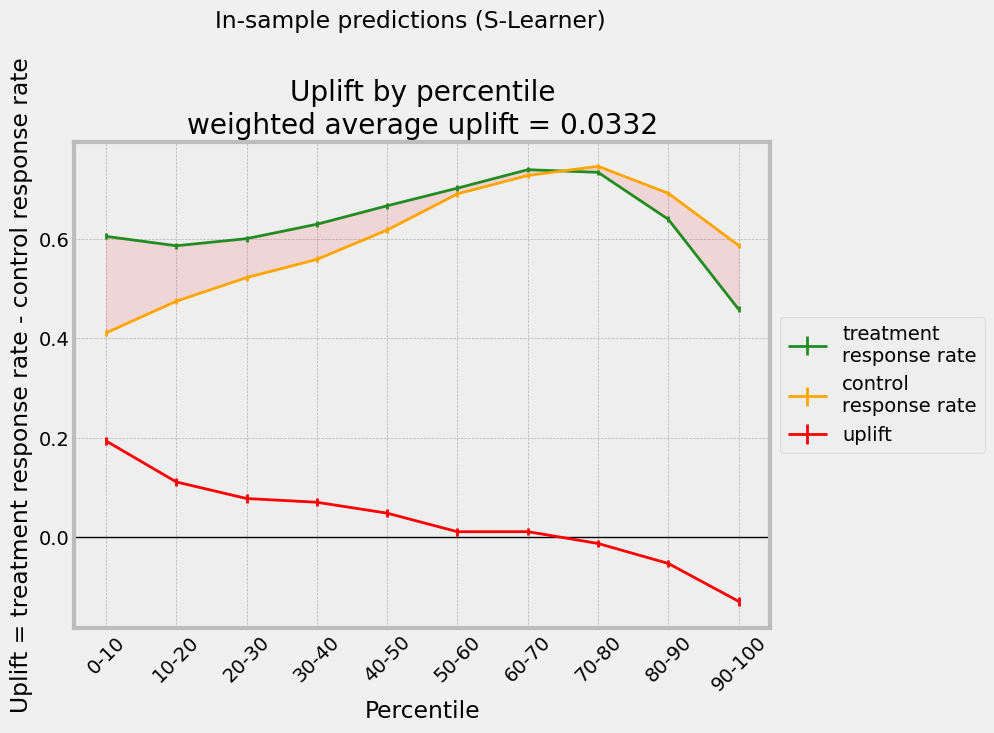

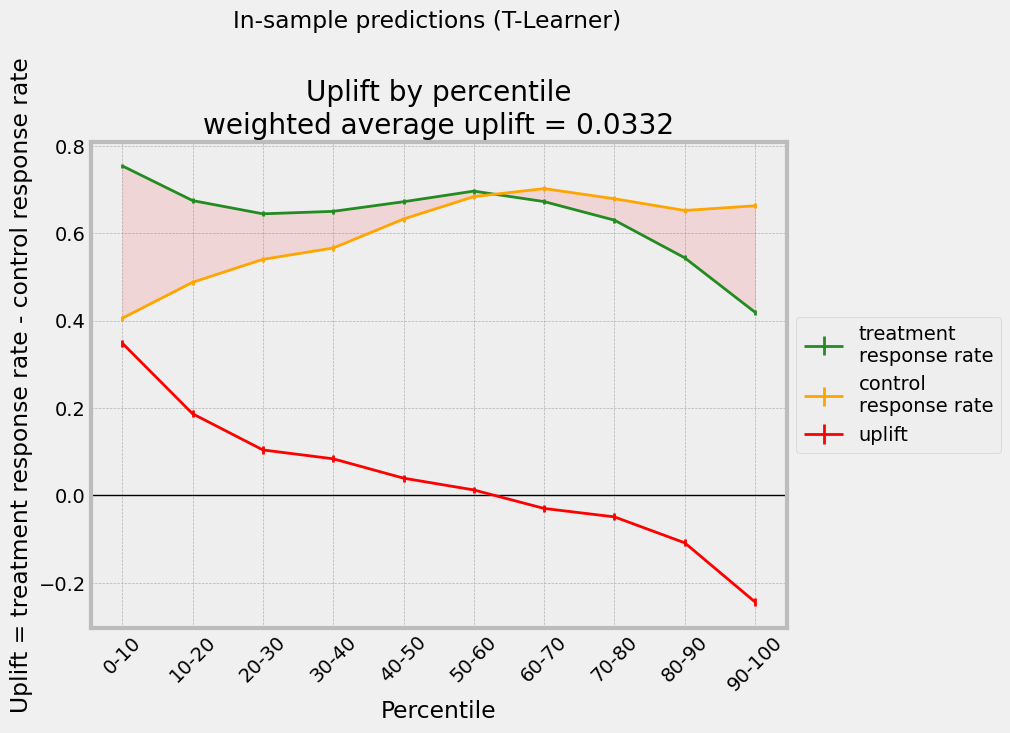

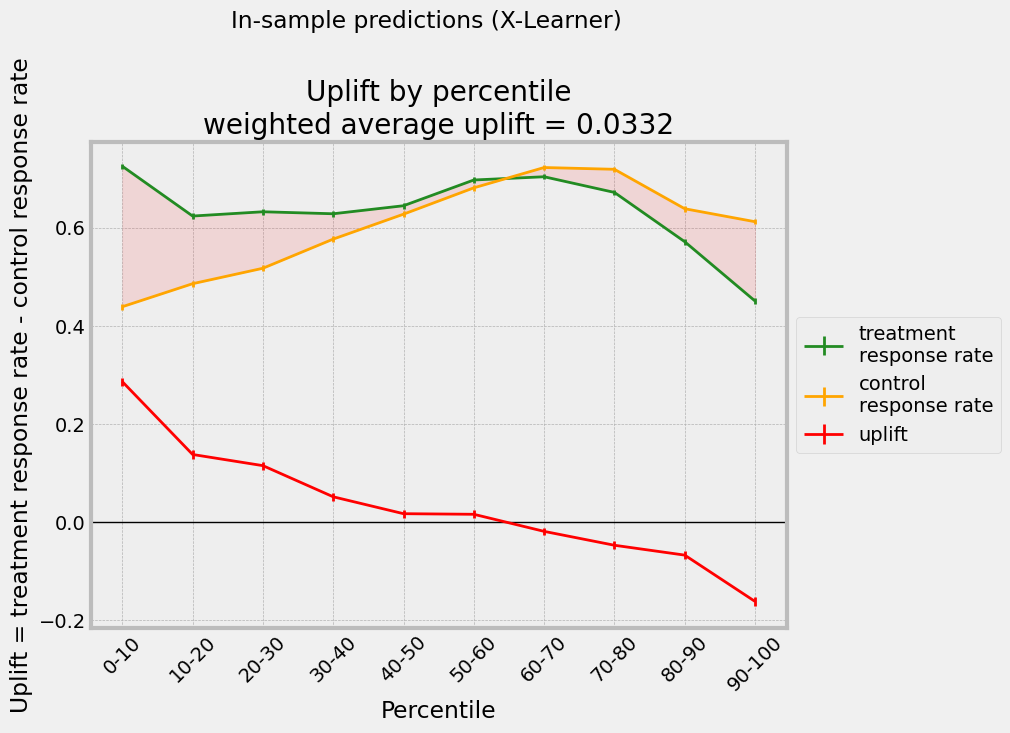

In [50]:
train_pred = [data_out_train_s, data_out_train_t, data_out_train_x]

for data_out_train in train_pred:
    ax = plot_uplift_by_percentile(
        y_true=data_train.y,
        uplift=data_out_train.y_pred.flatten(),
        treatment=data_train.treatment,
        strategy="overall",
        kind="line",
    )
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    fig = ax.get_figure()
    fig.suptitle(f"In-sample predictions ({data_out_train.meta_learner_name})", y=1.1)


## Why the uplift curve is not decreasing monotonically?
- How SLearner predict the uplift?
    - In sleaner.predict method, you'll find that it actually run the base model twice. One set treatment = 0, the other one set treatment = 1. Then it make prediction for ALL The data and calculate the difference (uplift).
- How does plot_uplift_by_percentile work?
    - y_true is the true label; uplift is from the model prediction; treatment indicates whether each unit receive the treatment or not.
    - It calls the `uplift_by_percentile` function and pass in the same parameter; `uplift_by_percentile` call `response_rate_by_percentile` twice, one for T and one for C group with the same parameters;
        - `uplift_by_percentile` divide data into bins based on 'uplift', which is the prediction from BaseLearner; Then it filter the corresponding unit based on 'group' (i.e. ['treatment', 'control']) and calculate the *TRUE* average response rate for each bin and return;
        - Then in `uplift_by_percentile` function, by subtracting response_rate_ctrl from response_rate_trmnt, we get the *TRUE* lift and plot the TRUE lift in red line.


#### Attention: To run the code successfully, I changed the source code of `uplift_by_percentile` in `../Library/Python/3.9/lib/python/site-packages/sklift/metrics/metrics.py` from `df.loc[-1, :] = ['total', n_trmnt_total, n_ctrl_total, response_rate_trmnt_total, response_rate_ctrl_total, response_rate_trmnt_total - response_rate_ctrl_total]` to `df.loc[-1, :] = ['total', n_trmnt_total[0], n_ctrl_total[0], response_rate_trmnt_total[0], response_rate_ctrl_total[0], response_rate_trmnt_total[0] - response_rate_ctrl_total[0]]`


/Users/yulin/Library/Python/3.9/lib/python/site-packages/sklift/metrics/metrics.py:716: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'total' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[-1, :] = ['total', n_trmnt_total[0], n_ctrl_total[0], response_rate_trmnt_totalv,
/Users/yulin/Library/Python/3.9/lib/python/site-packages/sklift/metrics/metrics.py:716: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'total' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[-1, :] = ['total', n_trmnt_total[0], n_ctrl_total[0], response_rate_trmnt_totalv,
/Users/yulin/Library/Python/3.9/lib/python/site-packages/sklift/metrics/metrics.py:716: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future v

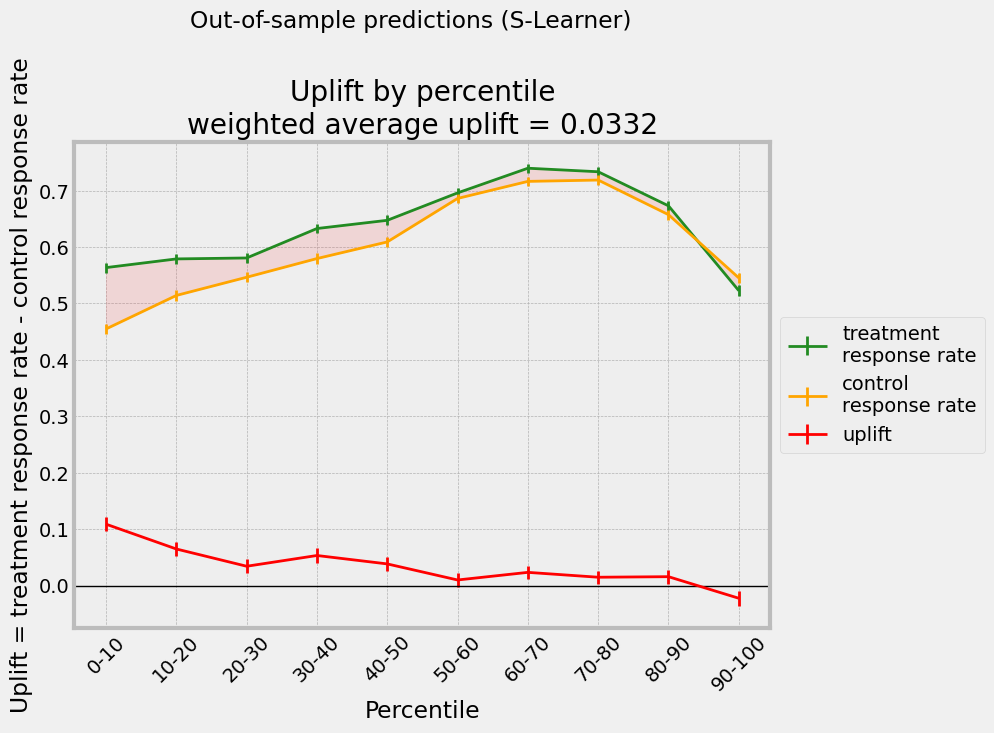

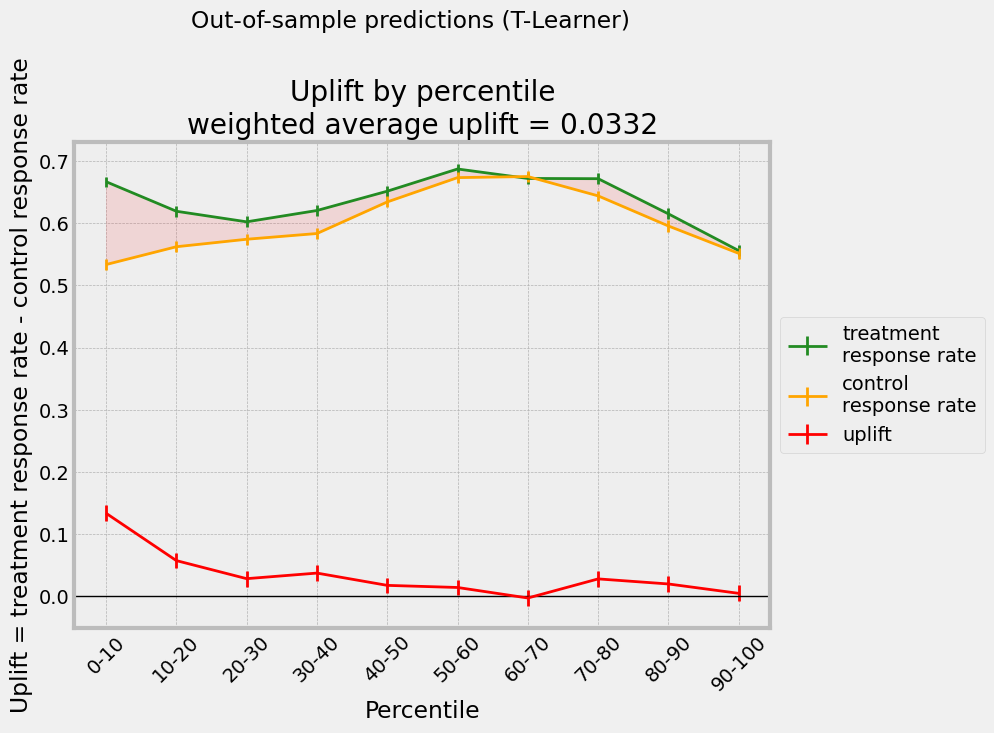

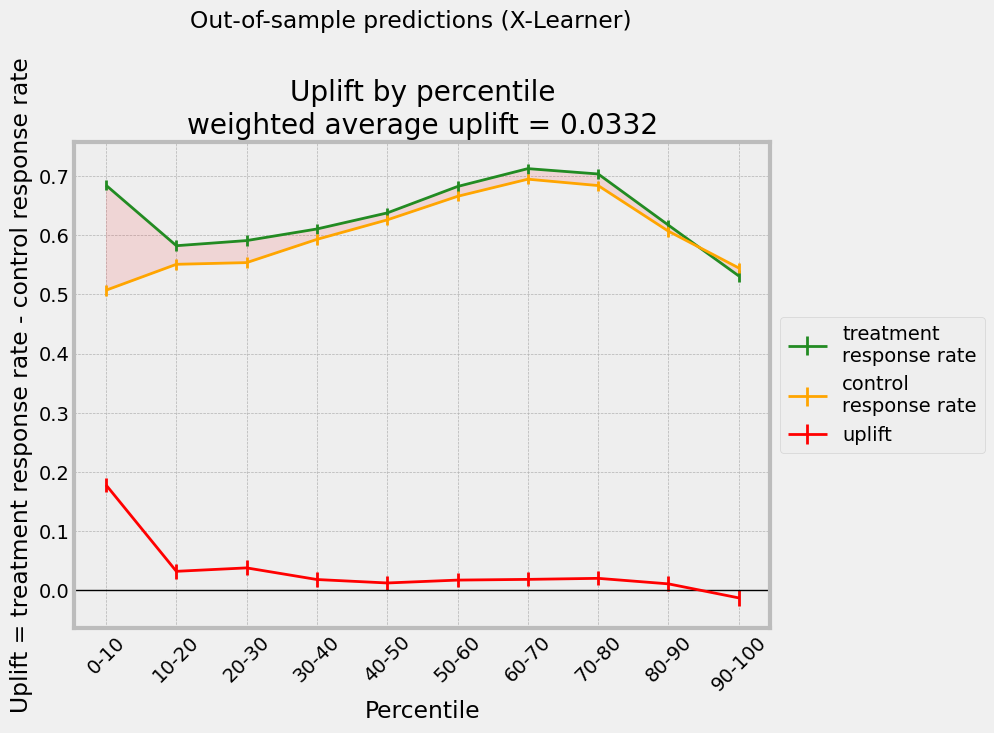

In [51]:
val_pred = [data_out_val_s, data_out_val_t, data_out_val_x]

for data_out_val in val_pred:
    ax = plot_uplift_by_percentile(
        y_true=data_val.y,
        uplift=data_out_val.y_pred.flatten(),
        treatment=data_val.treatment,
        strategy="overall",
        kind="line",
    )
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    fig = ax.get_figure()
    fig.suptitle(f"Out-of-sample predictions ({data_out_val.meta_learner_name})", y=1.1)


**Remark:** Here is the uplift by percentile table for the perfect model (train):

- Need to understand why the uplift_by_percentile df look like this:
    - The formula to get the perfect uplift score is `2 * [treatement == y_true] + (y_true if CR > TN else treatment)`, and in the training dataset, it's CR > TN, therefore the summand used is y_true
    - The perfect uplift score for the training data is:
        - CN = 2
        - CR = 1
        - TN = 0
        - TR = 3
    - In the df, 
        - we can see that from p0 - p30, they are all TR users, since they have the highest score (i.e. 3)
        - Then in p30-p40, 2539 TR and 11412 CN. Remember CN has the 2nd highest score (i.e. 2)
        - Then in p50-60, what happens here is we have both CN (score = 2) and CR (score = 1); Therefore the response rate in control group is no longer 0
        - Finally, we are in the zone of TN (score = 0) with 0 response rate.

In [91]:
cr_num = np.sum((data_train.y == 1) & (data_train.treatment == 0))
    # treated Non-Responders
tn_num = np.sum((data_train.y == 0) & (data_train.treatment == 1))

print(cr_num, tn_num)

42121 25327


In [52]:
uplift_by_percentile_df = uplift_by_percentile(
    y_true=data_train.y,
    uplift=perfect_uplift_train,
    treatment=data_train.treatment,
    strategy="overall",
    total=False,
)

uplift_by_percentile_df


/Users/yulin/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/yulin/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift
percentile,,,,,
0-10,13952,0,1.0,NaN,NaN
10-20,13952,0,1.0,NaN,NaN
20-30,13952,0,1.0,NaN,NaN
30-40,2539,11412,1.0,0.000000,1.0
40-50,0,13951,NaN,0.000000,NaN
50-60,0,13951,NaN,0.834636,NaN
60-70,0,13951,NaN,1.000000,NaN
70-80,0,13951,NaN,1.000000,NaN
80-90,11376,2575,0.0,1.000000,-1.0


### Cumulative gain chart

> *Predict uplift for both treated and control observations and compute the average prediction per decile (bins) in both groups. Then, the difference between those averages is taken for each decile.* ([Gutierrez, P., & Gérardy, J. Y. (2017). *"Causal Inference and Uplift Modelling: A Review of the Literature"*](https://proceedings.mlr.press/v67/gutierrez17a/gutierrez17a.pdf))

$$
\left(
\frac{Y^{T}}{N^{T}}
-
\frac{Y^{C}}{N^{C}}
\right)
(N^{T} + N^{C})
$$

> - $Y^{T} / Y^{C}$: sum of the treated / control individual outcomes  in the bin.
> - $N^{T} / N^{C}$: number of treated / control observations  in the bin.

We can compute this from the tables above. For example, for the S learner:

In [71]:
perfect_uplift_train

client_id
19bda15ee9    3.0
fc34cdfa96    0.0
6b4778b5af    1.0
6dee8c2f69    0.0
a7f6dbdf5b    3.0
             ... 
4cabe73d9c    1.0
51b60c4159    2.0
9896c4f2d7    1.0
549ca4f5c7    3.0
3f77ac6044    2.0
Length: 139513, dtype: float64

[Text(0.5, 1.0, 'Cumulative gain by percentile - S Learned (train)'),
 Text(0, 0.5, 'cumulative gain')]

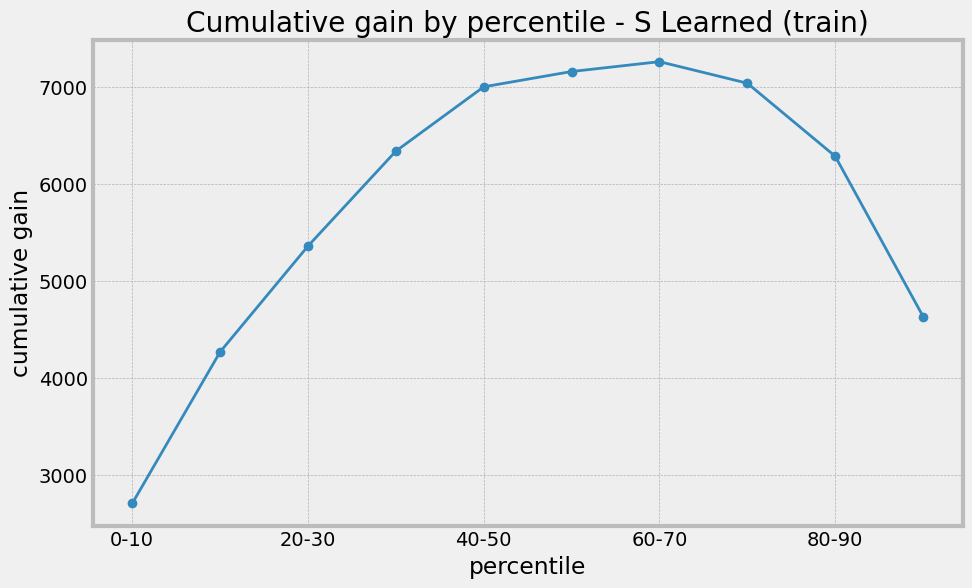

In [72]:
uplift_by_percentile_df = uplift_by_percentile(
    y_true=data_train.y,
    uplift=data_out_train_s.y_pred.flatten(),
    treatment=data_train.treatment,
    strategy="overall",
    total=False,
)

# uplift_by_percentile_df = uplift_by_percentile(
#     y_true=data_train.y,
#     uplift=perfect_uplift_train,
#     treatment=data_train.treatment,
#     strategy="overall",
#     total=False,
# )

def compute_response_absolutes(df: pd.DataFrame) -> pd.DataFrame:
    df["responses_treatment"] = df["n_treatment"] * df["response_rate_treatment"]
    df["responses_control"] = df["n_control"] * df["response_rate_control"]
    return df


def compute_cumulative_response_rates(df: pd.DataFrame) -> pd.DataFrame:
    df["n_treatment_cumsum"] = df["n_treatment"].cumsum()
    df["n_control_cumsum"] = df["n_control"].cumsum()
    df["responses_treatment_cumsum"] = df["responses_treatment"].cumsum()
    df["responses_control_cumsum"] = df["responses_control"].cumsum()
    df["response_rate_treatment_cumsum"] = (
        df["responses_treatment_cumsum"] / df["n_treatment_cumsum"]
    )
    df["response_rate_control_cumsum"] = (
        df["responses_control_cumsum"] / df["n_control_cumsum"]
    )
    return df


def compute_cumulative_gain(df: pd.DataFrame) -> pd.DataFrame:
    df["uplift_cumsum"] = (
        df["response_rate_treatment_cumsum"] - df["response_rate_control_cumsum"]
    )
    df["cum_gain"] = df["uplift_cumsum"] * (
        df["n_treatment_cumsum"] + df["n_control_cumsum"]
    )
    return df


fig, ax = plt.subplots()

uplift_by_percentile_df.pipe(compute_response_absolutes).pipe(
    compute_cumulative_response_rates
).pipe(compute_cumulative_gain).plot(y="cum_gain", kind="line", marker="o", ax=ax)
ax.legend().remove()
ax.set(
    title="Cumulative gain by percentile - S Learned (train)", ylabel="cumulative gain"
)


**Remark:** From [Gutierrez, P., & Gérardy, J. Y. (2017). *"Causal Inference and Uplift Modelling: A Review of the Literature"*](https://proceedings.mlr.press/v67/gutierrez17a/gutierrez17a.pdf), 
> This is useful to marketers because they can easily see if the treatment has a global positive or negative effect and if they can expect a better gain by targeting part of the population. We can thus choose the decile that maximizes the gain as the limit of the population to be targeted.

### Uplift Curve

> *We can generalize the cumulative gain chart for each observation of the test set:*

$$
f(t)
=
\left(
\frac{Y^{T}_{t}}{N^{T}_{t}}
-
\frac{Y^{C}_{t}}{N^{C}_{t}}
\right)
(N^{T}_{t} + N^{C}_{t})
$$

> *where the $t$ subscript indicates that the quantity is calculated for the first $t$ observations, sorted by inferred uplift value.* ([Gutierrez, P., & Gérardy, J. Y. (2017). "Causal Inference and Uplift Modelling: A Review of the Literature"](https://proceedings.mlr.press/v67/gutierrez17a/gutierrez17a.pdf))

In [79]:
data_train.y[data_out_train_s.y_pred.flatten() >= 0]

client_id
19bda15ee9    1.0
fc34cdfa96    0.0
6b4778b5af    1.0
6dee8c2f69    0.0
a7f6dbdf5b    1.0
             ... 
4cabe73d9c    1.0
51b60c4159    0.0
9896c4f2d7    1.0
549ca4f5c7    1.0
3f77ac6044    0.0
Name: target, Length: 139513, dtype: float64

In [77]:
data_out_train_s.y_pred.flatten()[data_out_train_s.y_pred.flatten() >= 0]

array([0.05567928, 0.04218653, 0.0035638 , ..., 0.05760898, 0.00744607,
       0.04397559])

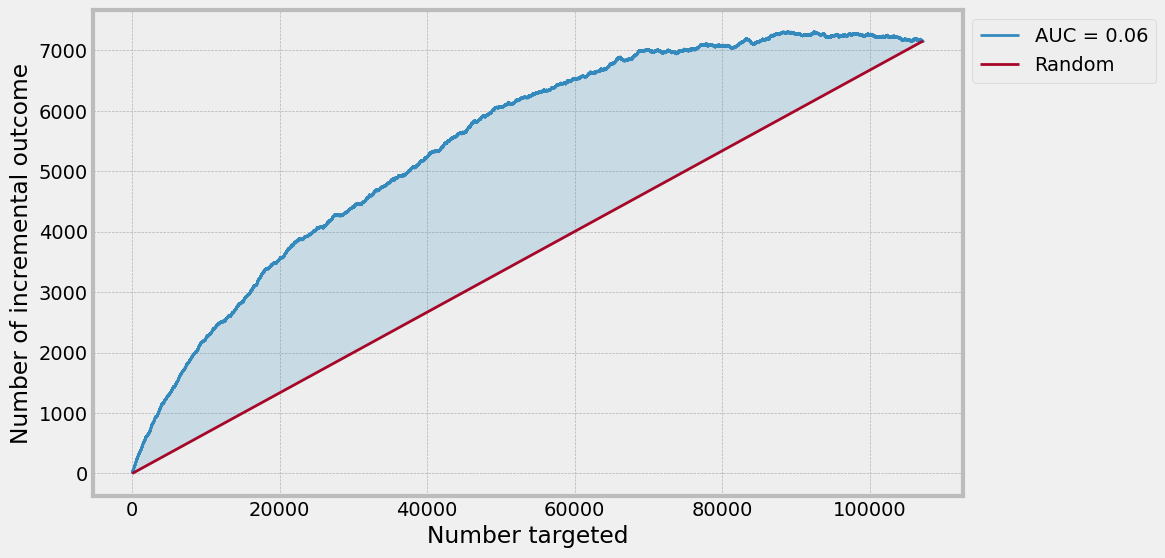

In [87]:
plot_uplift_curve(
        y_true=data_train.y[data_out_train_s.y_pred.flatten() > 0],
        uplift=data_out_train_s.y_pred.flatten()[data_out_train_s.y_pred.flatten() > 0],
        treatment=data_train.treatment[data_out_train_s.y_pred.flatten() > 0],
        perfect=False,
    )

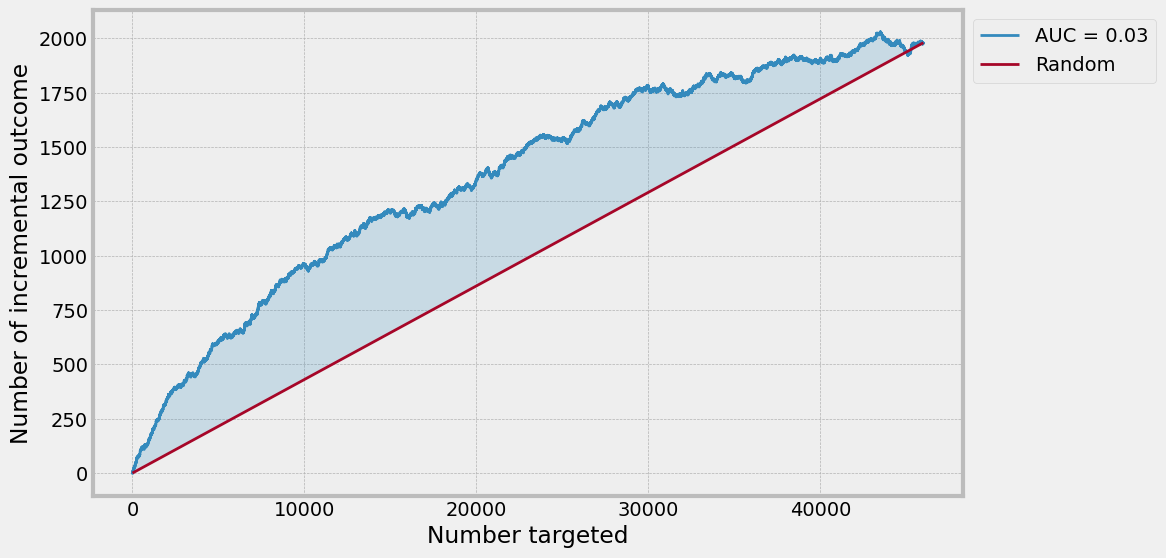

In [89]:
plot_uplift_curve(
        y_true=data_val.y[data_out_val_s.y_pred.flatten() > 0],
        uplift=data_out_val_s.y_pred.flatten()[data_out_val_s.y_pred.flatten() > 0],
        treatment=data_val.treatment[data_out_val_s.y_pred.flatten() > 0],
        perfect=False,
    )

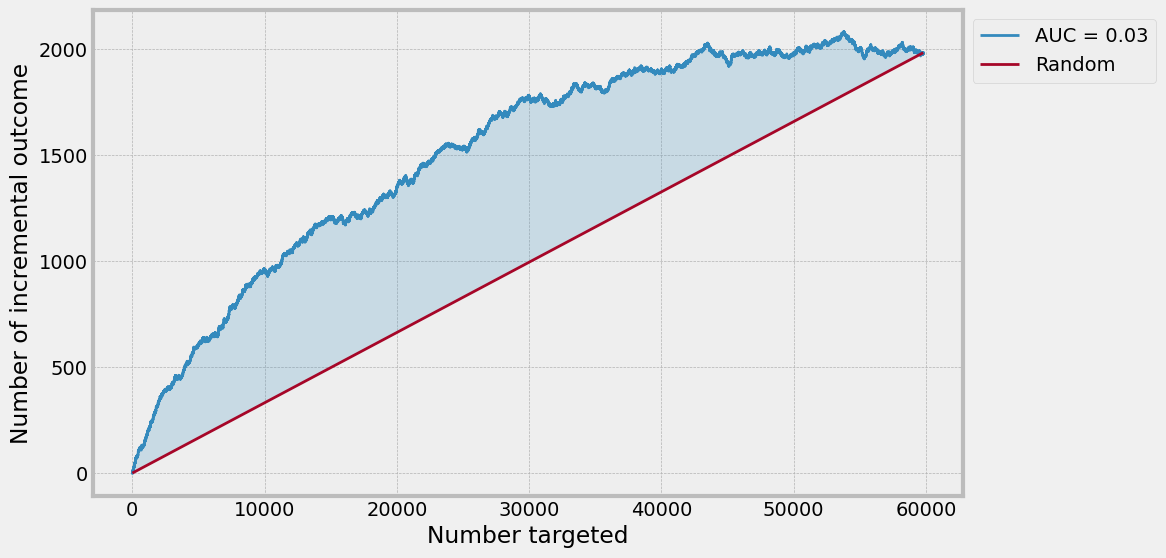

In [88]:
plot_uplift_curve(
        y_true=data_val.y#[data_out_val_s.y_pred.flatten() > 0],
        ,uplift=data_out_val_s.y_pred.flatten()#[data_out_val_s.y_pred.flatten() > 0],
        ,treatment=data_val.treatment#[data_out_val_s.y_pred.flatten() > 0],
        ,perfect=False,
    )

Text(0.5, 0.98, 'Uplift Curves')

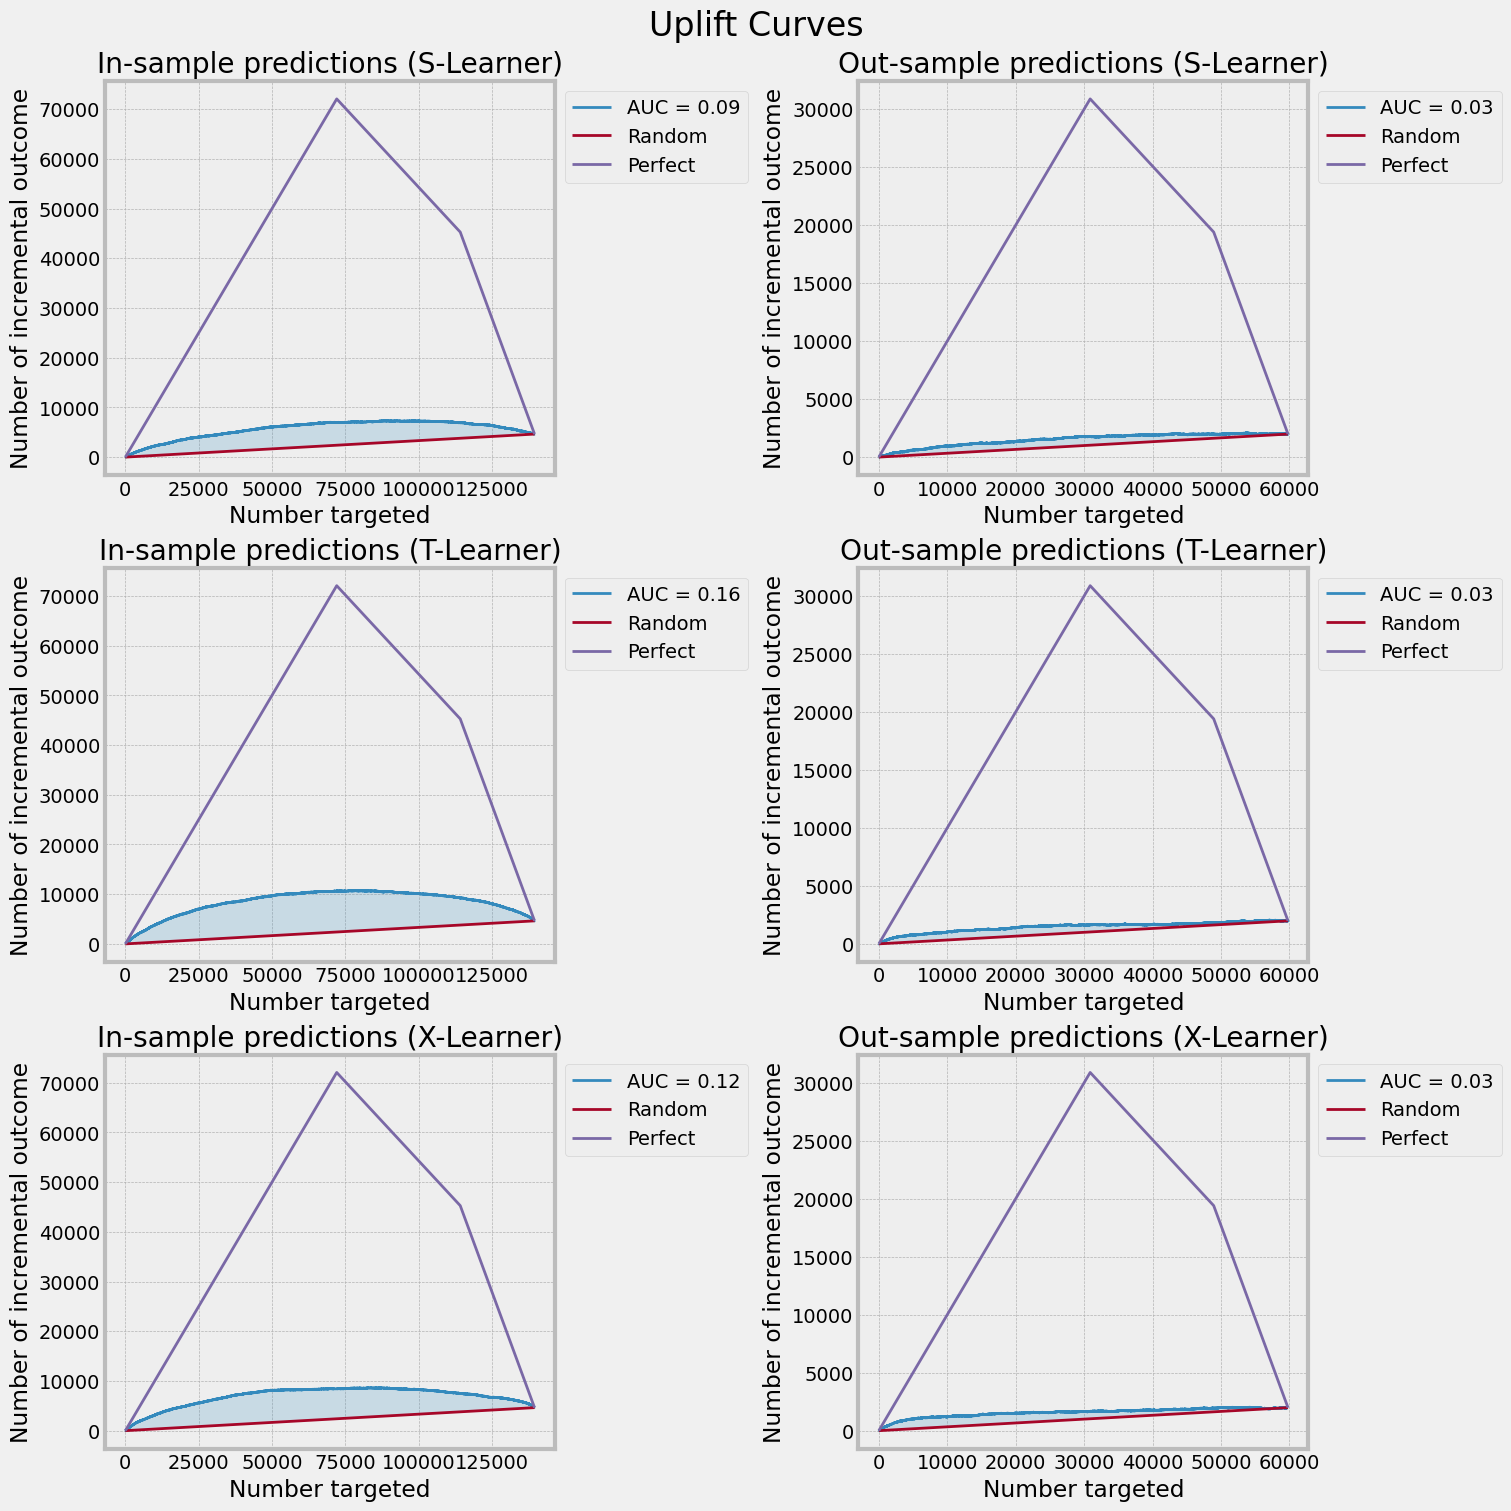

In [92]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15), layout="constrained")
# in-sample
for i, data_out_train in enumerate(train_pred):
    ax = axes[i, 0]
    plot_uplift_curve(
        y_true=data_train.y,
        uplift=data_out_train.y_pred.flatten(),
        treatment=data_train.treatment,
        perfect=True,
        ax=ax,
    )
    ax.set(title=f"In-sample predictions ({data_out_train.meta_learner_name})")

# out-of-sample
for j, data_out_val in enumerate(val_pred):
    ax = axes[j, 1]
    plot_uplift_curve(
        y_true=data_val.y,
        uplift=data_out_val.y_pred.flatten(),
        treatment=data_val.treatment,
        perfect=True,
        ax=ax,
    )
    ax.set(title=f"Out-sample predictions ({data_out_val.meta_learner_name})")

fig.suptitle("Uplift Curves", fontsize=24)


**A remark on the perfect uplift curve:** ([Diemert, Eustache, et.al. (2020) "A Large Scale Benchmark for Uplift Modeling"](http://ama.imag.fr/~amini/Publis/large-scale-benchmark.pdf))
> A perfect model assigns higher scores to all treated individuals
with positive outcomes than any individuals with negative outcomes.

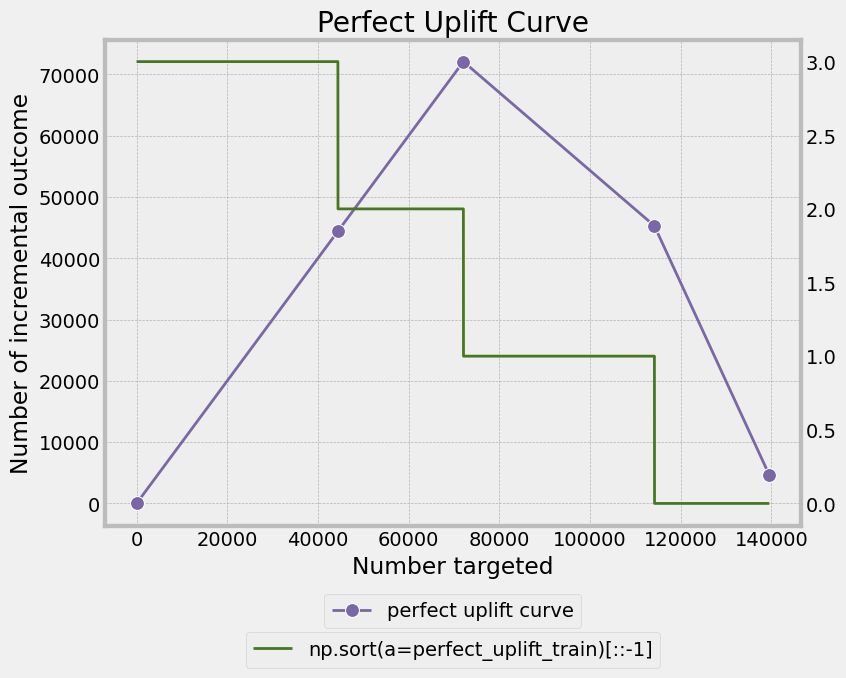

In [59]:
from sklift.metrics import uplift_curve

num_all, curve_values = uplift_curve(
    y_true=data_train.y, uplift=perfect_uplift_train, treatment=data_train.treatment
)

fig, ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()
sns.lineplot(
    x=num_all,
    y=curve_values,
    color="C2",
    marker="o",
    markersize=10,
    label="perfect uplift curve",
    ax=ax1,
)
sns.lineplot(
    x=range(data_train.y.size),
    y=np.sort(a=perfect_uplift_train)[::-1],
    color="C3",
    label="np.sort(a=perfect_uplift_train)[::-1]",
    ax=ax2,
)
ax1.legend(loc="upper center", bbox_to_anchor=(0.5, -0.12), ncol=1)
ax1.set(
    xlabel="Number targeted",
    ylabel="Number of incremental outcome",
    title="Perfect Uplift Curve",
)
ax2.grid(None)
ax2.legend(loc="upper center", bbox_to_anchor=(0.5, -0.20), ncol=1)


We can compare the perfect uplift curve against a random one:

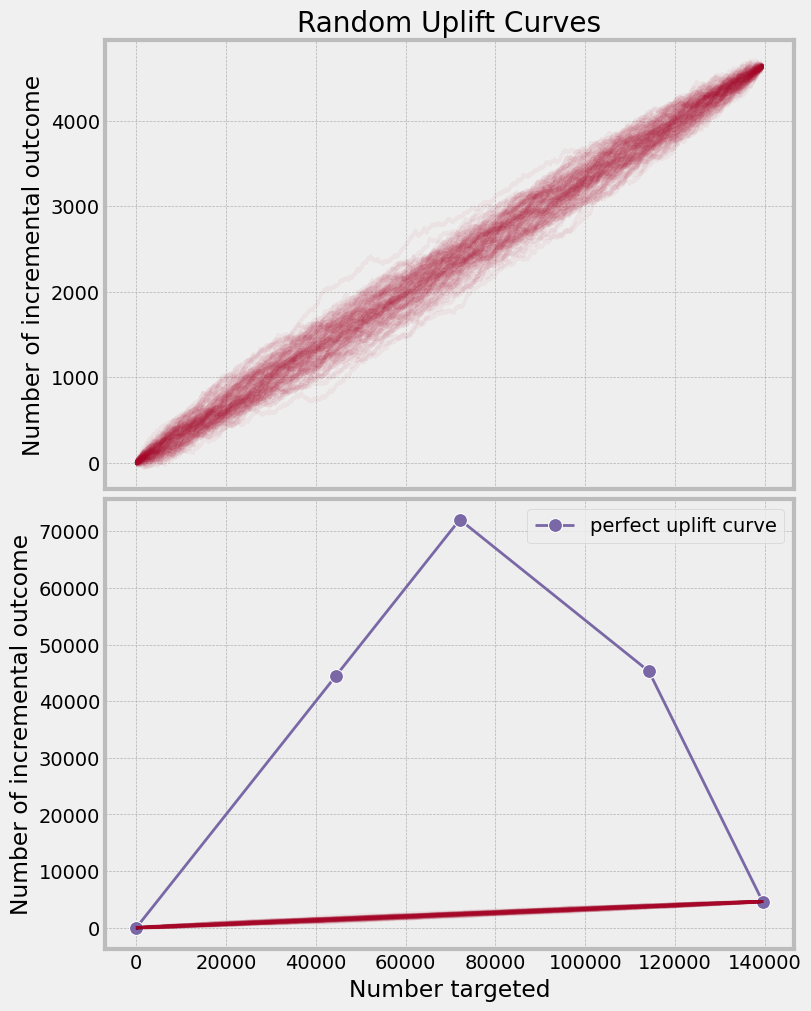

In [44]:
# number of random uplift curves to generate
n_random_samples = 100
# sample random uplift curves from a uniform distribution
uplift_random_samples = np.random.uniform(
    low=-1,
    high=1,
    size=(data_train.y.size, n_random_samples),
)
# compute uplift curve for each random sample
random_uplift_curves = [
    uplift_curve(
        y_true=data_train.y,
        uplift=uplift_random_samples[:, i],
        treatment=data_train.treatment,
    )
    for i in range(n_random_samples)
]

# plot
fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(8, 10), sharex=True, layout="constrained"
)
# perfect uplift curve
sns.lineplot(
    x=num_all,
    y=curve_values,
    color="C2",
    marker="o",
    markersize=10,
    label="perfect uplift curve",
    ax=ax[1],
)
# random uplift curves
for x, y in random_uplift_curves:
    ax[0].plot(x, y, color="C1", alpha=0.05)
    ax[1].plot(x, y, color="C1", alpha=0.05)
ax[0].set(title="Random Uplift Curves", ylabel="Number of incremental outcome")
ax[1].set(xlabel="Number targeted", ylabel="Number of incremental outcome")


### Qini Curve

There is another variant for measuring the uplift, the *Qini curve*. It is defined as follows:

$$
g(t)
=
Y^{T}_{t}
-
Y^{C}_{t}
\left(
\frac{N^{T}_{t}}{N^{C}_{t}}
\right)
$$

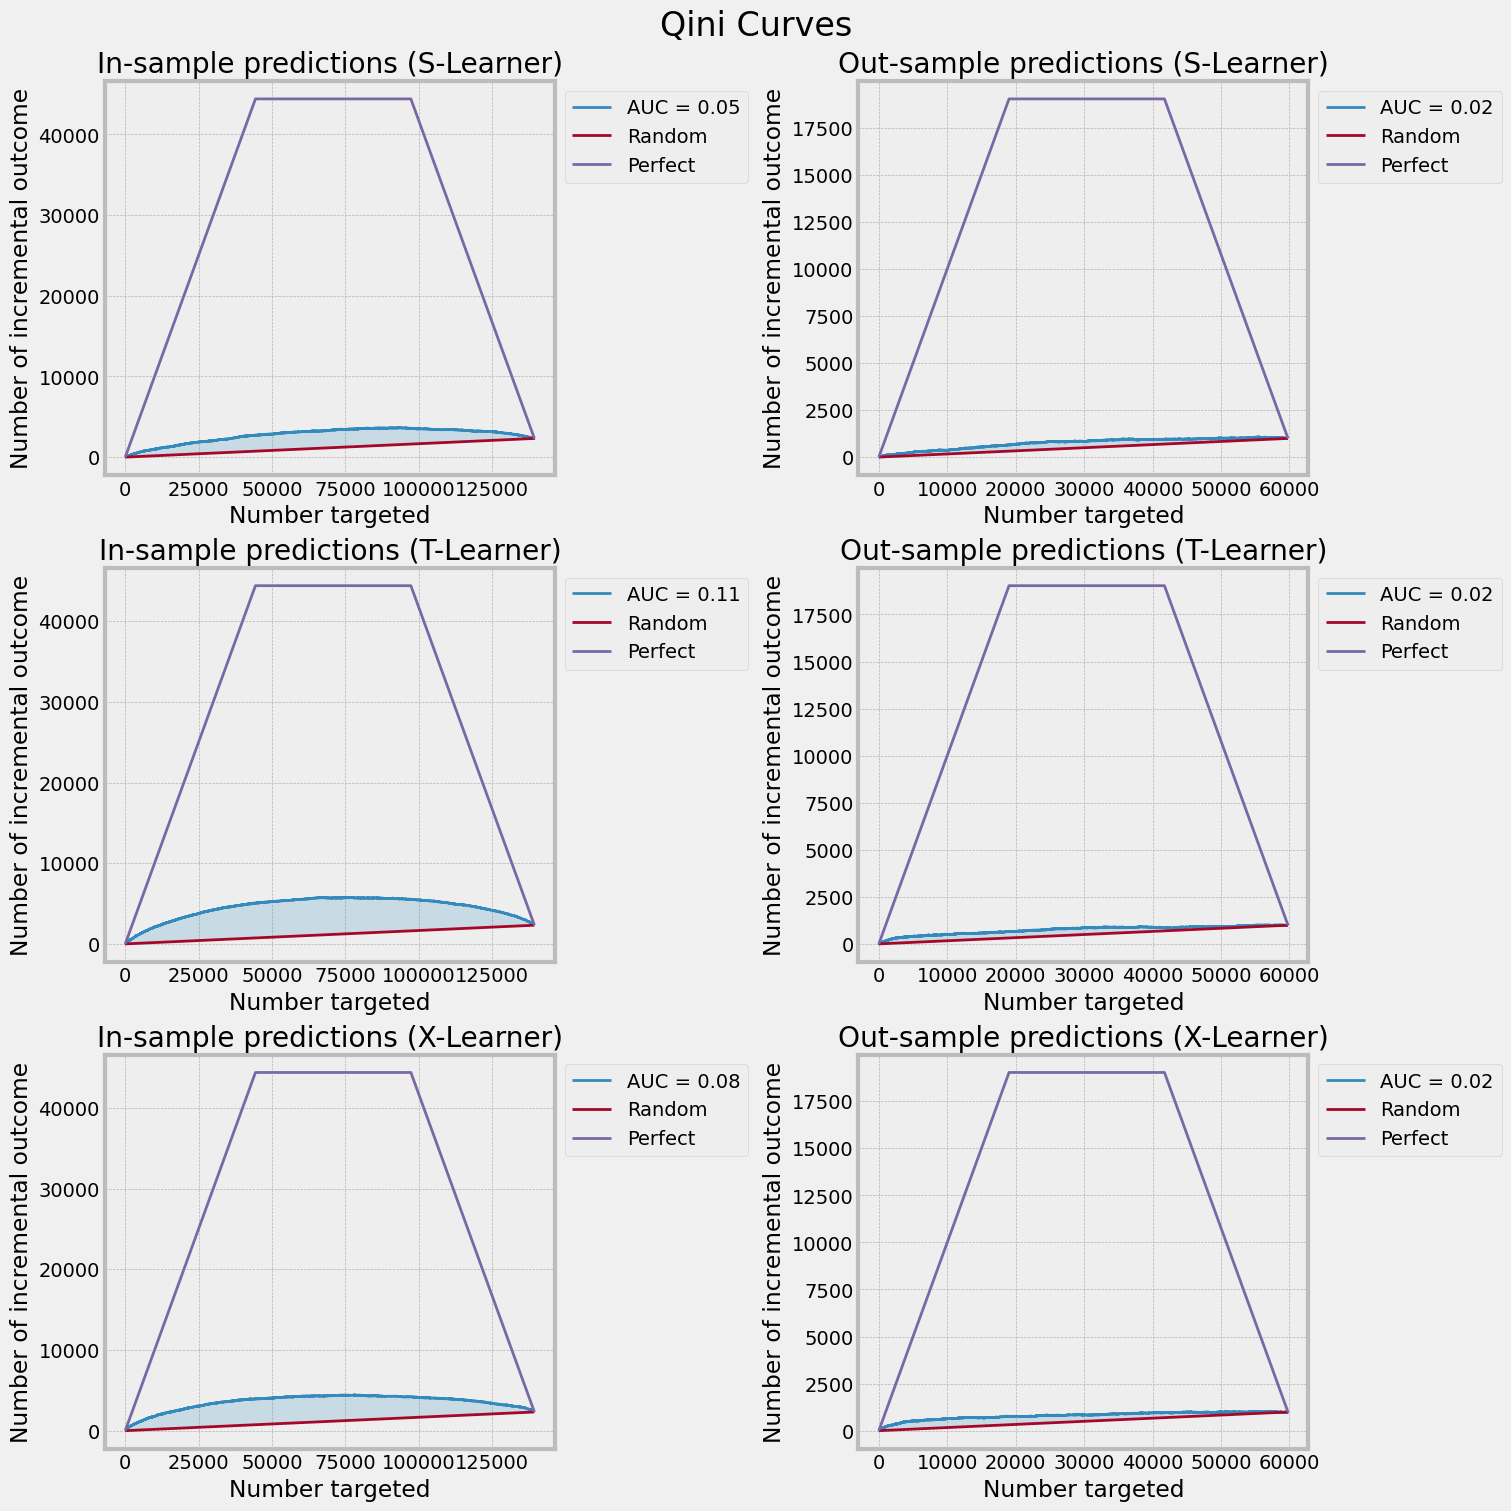

In [45]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15), layout="constrained")
# in-sample
for i, data_out_train in enumerate(train_pred):
    ax = axes[i, 0]
    plot_qini_curve(
        y_true=data_train.y,
        uplift=data_out_train.y_pred.flatten(),
        treatment=data_train.treatment,
        perfect=True,
        ax=ax,
    )
    ax.set(title=f"In-sample predictions ({data_out_train.meta_learner_name})")

# out-of-sample
for j, data_out_val in enumerate(val_pred):
    ax = axes[j, 1]
    plot_qini_curve(
        y_true=data_val.y,
        uplift=data_out_val.y_pred.flatten(),
        treatment=data_val.treatment,
        perfect=True,
        ax=ax,
    )
    ax.set(title=f"Out-sample predictions ({data_out_val.meta_learner_name})")

fig.suptitle("Qini Curves", fontsize=24)


For more details on the Qini curve an related metrics see Section 4 in [Diemert, Eustache, et.al. (2020) *"A Large Scale Benchmark for Uplift Modeling"*](http://ama.imag.fr/~amini/Publis/large-scale-benchmark.pdf).

## Why the uplift curve is not decreasing monotonically?
- How SLearner predict the uplift?
    - In sleaner.predict method, you'll find that it actually run the base model twice. One set treatment = 0, the other one set treatment = 1. Then it make prediction for ALL The data and calculate the difference (uplift).
- How does plot_uplift_by_percentile work?
    - y_true is the true label; uplift is from the model prediction; treatment indicates whether each unit receive the treatment or not.
    - It calls the `uplift_by_percentile` function and pass in the same parameter; `uplift_by_percentile` call `response_rate_by_percentile` twice, one for T and one for C group with the same parameters;
        - `uplift_by_percentile` divide data into bins based on 'uplift', which is the prediction from BaseLearner; Then it filter the corresponding unit based on 'group' (i.e. ['treatment', 'control']) and calculate the *TRUE* average response rate for each bin and return;
        - Then in `uplift_by_percentile` function, by subtracting response_rate_ctrl from response_rate_trmnt, we get the *TRUE* lift and plot the TRUE lift in red line.


#### Attention: To run the code successfully, I changed the source code of `uplift_by_percentile` in `../Library/Python/3.9/lib/python/site-packages/sklift/metrics/metrics.py` from `df.loc[-1, :] = ['total', n_trmnt_total, n_ctrl_total, response_rate_trmnt_total, response_rate_ctrl_total, response_rate_trmnt_total - response_rate_ctrl_total]` to `df.loc[-1, :] = ['total', n_trmnt_total[0], n_ctrl_total[0], response_rate_trmnt_total[0], response_rate_ctrl_total[0], response_rate_trmnt_total[0] - response_rate_ctrl_total[0]]`
